In [2]:
!pip install tensorflow==2.0.0-beta

     |████████████████████████████████| 87.9MB 33kB/s 
     |████████████████████████████████| 3.1MB 58.2MB/s 
     |████████████████████████████████| 501kB 56.9MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, utils, Model
from tensorflow.keras import layers, utils, Model
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [2]:
class GoogleNet():

    def __init__(self, kernel_initializer, kernel_regularizer, gamma_initializer, dropout, epsilon, weight_decay, momentum):

        self.kernel_regularizer = kernel_regularizer
        self.kernel_initializer = kernel_initializer
        self.gamma_initializer = gamma_initializer
        self.dropout = dropout
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.momentum = momentum
    
    def auxiliary_block(self, x, name):
      
        avg_pool = AveragePooling2D((5, 5), strides=3)(x)
        cnv = Conv2D(128, (1,1), padding='same', activation='relu')(avg_pool)
        flt = Flatten()(cnv)
        dense = Dense(1024, activation='relu')(flt)
        dense_drpt = Dropout(self.dropout)(dense)  
        auxiliary_out = Dense(1000, activation='softmax', name='auxiliary_out'+name)(dense_drpt)

        return auxiliary_out


    def inception_block(self, x, f_1x1, f_3x3_red, f_3x3, f_5x5_red, f_5x5, f_pool, name):

        conv1_1x1 = Conv2D(f_1x1, (1,1), padding='same', 
                           kernel_regularizer=l2(self.kernel_regularizer),
                           name=name+"_conv1_1x1")(x)
        conv2_3x3_red = Conv2D(f_3x3_red, (1, 1), padding='same', 
                               kernel_regularizer=l2(self.kernel_regularizer), 
                               name=name+"_conv2_3x3_red")(x)
        conv2_3x3 = Conv2D(f_3x3, (3,3), padding='same', 
                           kernel_regularizer=l2(self.kernel_regularizer), 
                           name=name+"_conv2_3x3")(conv2_3x3_red)
        conv2_5x5_red = Conv2D(f_5x5_red, (1, 1), padding='same', 
                               kernel_regularizer=l2(self.kernel_regularizer), 
                               name=name+"_conv2_5x5_red")(x)
        conv2_5x5 = Conv2D(f_5x5, (5,5), padding='same', 
                           kernel_regularizer=l2(self.kernel_regularizer), 
                           name=name+"_conv2_5x5")(conv2_5x5_red)
        max_pool = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
        conv_1x1 = Conv2D(f_pool, (1, 1), padding='same', activation='relu', 
                          kernel_regularizer=l2(self.kernel_regularizer), 
                          name=name+"_conv_1x1")(max_pool)

        output = concatenate([conv1_1x1, conv2_3x3, conv2_5x5, conv_1x1], axis=3, name=name)
    
        return output


    def build_model(self, input_dim):
         
        conv1_7x7 = Conv2D(filters=64, kernel_size=(7, 7), padding='same', strides = (2,2), 
                           activation="relu", name='conv1_7x7')(input_dim)
        max_pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", 
                                  name='max_pool_1')(conv1_7x7)
        inc_lrn_1 = tf.nn.local_response_normalization(max_pool_1, name="inc_lrn_1")

        conv_2a_3x3 = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', 
                             name='conv_2a_3x3')(inc_lrn_1)
        conv2_3x3 = Conv2D(192, (3,3), padding='same', name='conv_2b_3x3', 
                           kernel_regularizer=l2(self.kernel_regularizer), strides = 1, 
                           use_bias=False)(conv_2a_3x3)
        max_pool_2 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), 
                                  padding="same", name='max_pool_2')(conv2_3x3)

        inception_3a = self.inception_block(max_pool_2, f_1x1=64, f_3x3_red=96,
                          f_3x3=128, f_5x5_red=16, f_5x5=32, f_pool=32, name='incept_3a')
        inception_3b = self.inception_block(inception_3a, f_1x1=128, f_3x3_red=128, 
                          f_3x3=192, f_5x5_red=32, f_5x5=96, f_pool=64, name='incept_3b')
        max_pool_3 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", 
                                  name='max_pool_3')(inception_3b)

        inception_4a = self.inception_block(max_pool_3, f_1x1=192, f_3x3_red=96, 
                                            f_3x3=208, f_5x5_red=16, f_5x5=48, 
                                            f_pool=64, name='incept_4a')
        aux_4a = self.auxiliary_block(inception_4a,"_4a")
        inception_4b = self.inception_block(inception_4a, f_1x1=160, f_3x3_red=112, 
                                            f_3x3=224, f_5x5_red=24, f_5x5=64, 
                                            f_pool=64, name='incept_4b')
        inception_4c = self.inception_block(inception_4b, f_1x1=128, f_3x3_red=128, 
                                            f_3x3=256, f_5x5_red=24, f_5x5=64, 
                                            f_pool=64, name='incept_4c')
        inception_4d = self.inception_block(inception_4c, f_1x1=112, f_3x3_red=144, 
                                            f_3x3=288, f_5x5_red=32, f_5x5=64, 
                                            f_pool=64, name='incept_4d')
        aux_4d = self.auxiliary_block(inception_4d,"_4d")
        inception_4e = self.inception_block(inception_4d, f_1x1=256, f_3x3_red=160, 
                                            f_3x3=320, f_5x5_red=32, f_5x5=128, 
                                            f_pool=128, name='incept_4e')

        max_pool_4 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding="same", 
                                  name='max_pool_4')(inception_4e)
        inception_5a = self.inception_block(max_pool_4, f_1x1=256, f_3x3_red=160, 
                                            f_3x3=320, f_5x5_red=32, f_5x5=128, 
                                            f_pool=128, name='incept_5a')
        inception_5b = self.inception_block(inception_5a, f_1x1=384, f_3x3_red=192, 
                                            f_3x3=384, f_5x5_red=48, f_5x5=128, 
                                            f_pool=128, name='incept_5b')

        avg_pool = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), 
                              padding="valid", name="avg_pool_1")(inception_5b)
        dropout = Dropout((0.4))(avg_pool)
        linear = Dense(1000, activation='softmax')(dropout)
        
        model = Model(inputs, [linear, aux_4a, aux_4d])
        return model


if __name__ == "__main__":
    gnet = GoogleNet('he_normal', 0.0002, 'uniform', 0.7, 1e-5, 0.0005, 0.1)
    input = (224, 224, 3)
    inputs = Input(shape=input, name='input_layer')
    gn = gnet.build_model(inputs)

    gn.summary()
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_7x7 (Conv2D)              (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
max_pool_1 (MaxPooling2D)       (None, 56, 56, 64)   0           conv1_7x7[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_inc_lrn_1 (TensorFl [(None, 56, 56, 64)] 0           max_pool_1[0][0]                 
______________________________________________________________________________________________

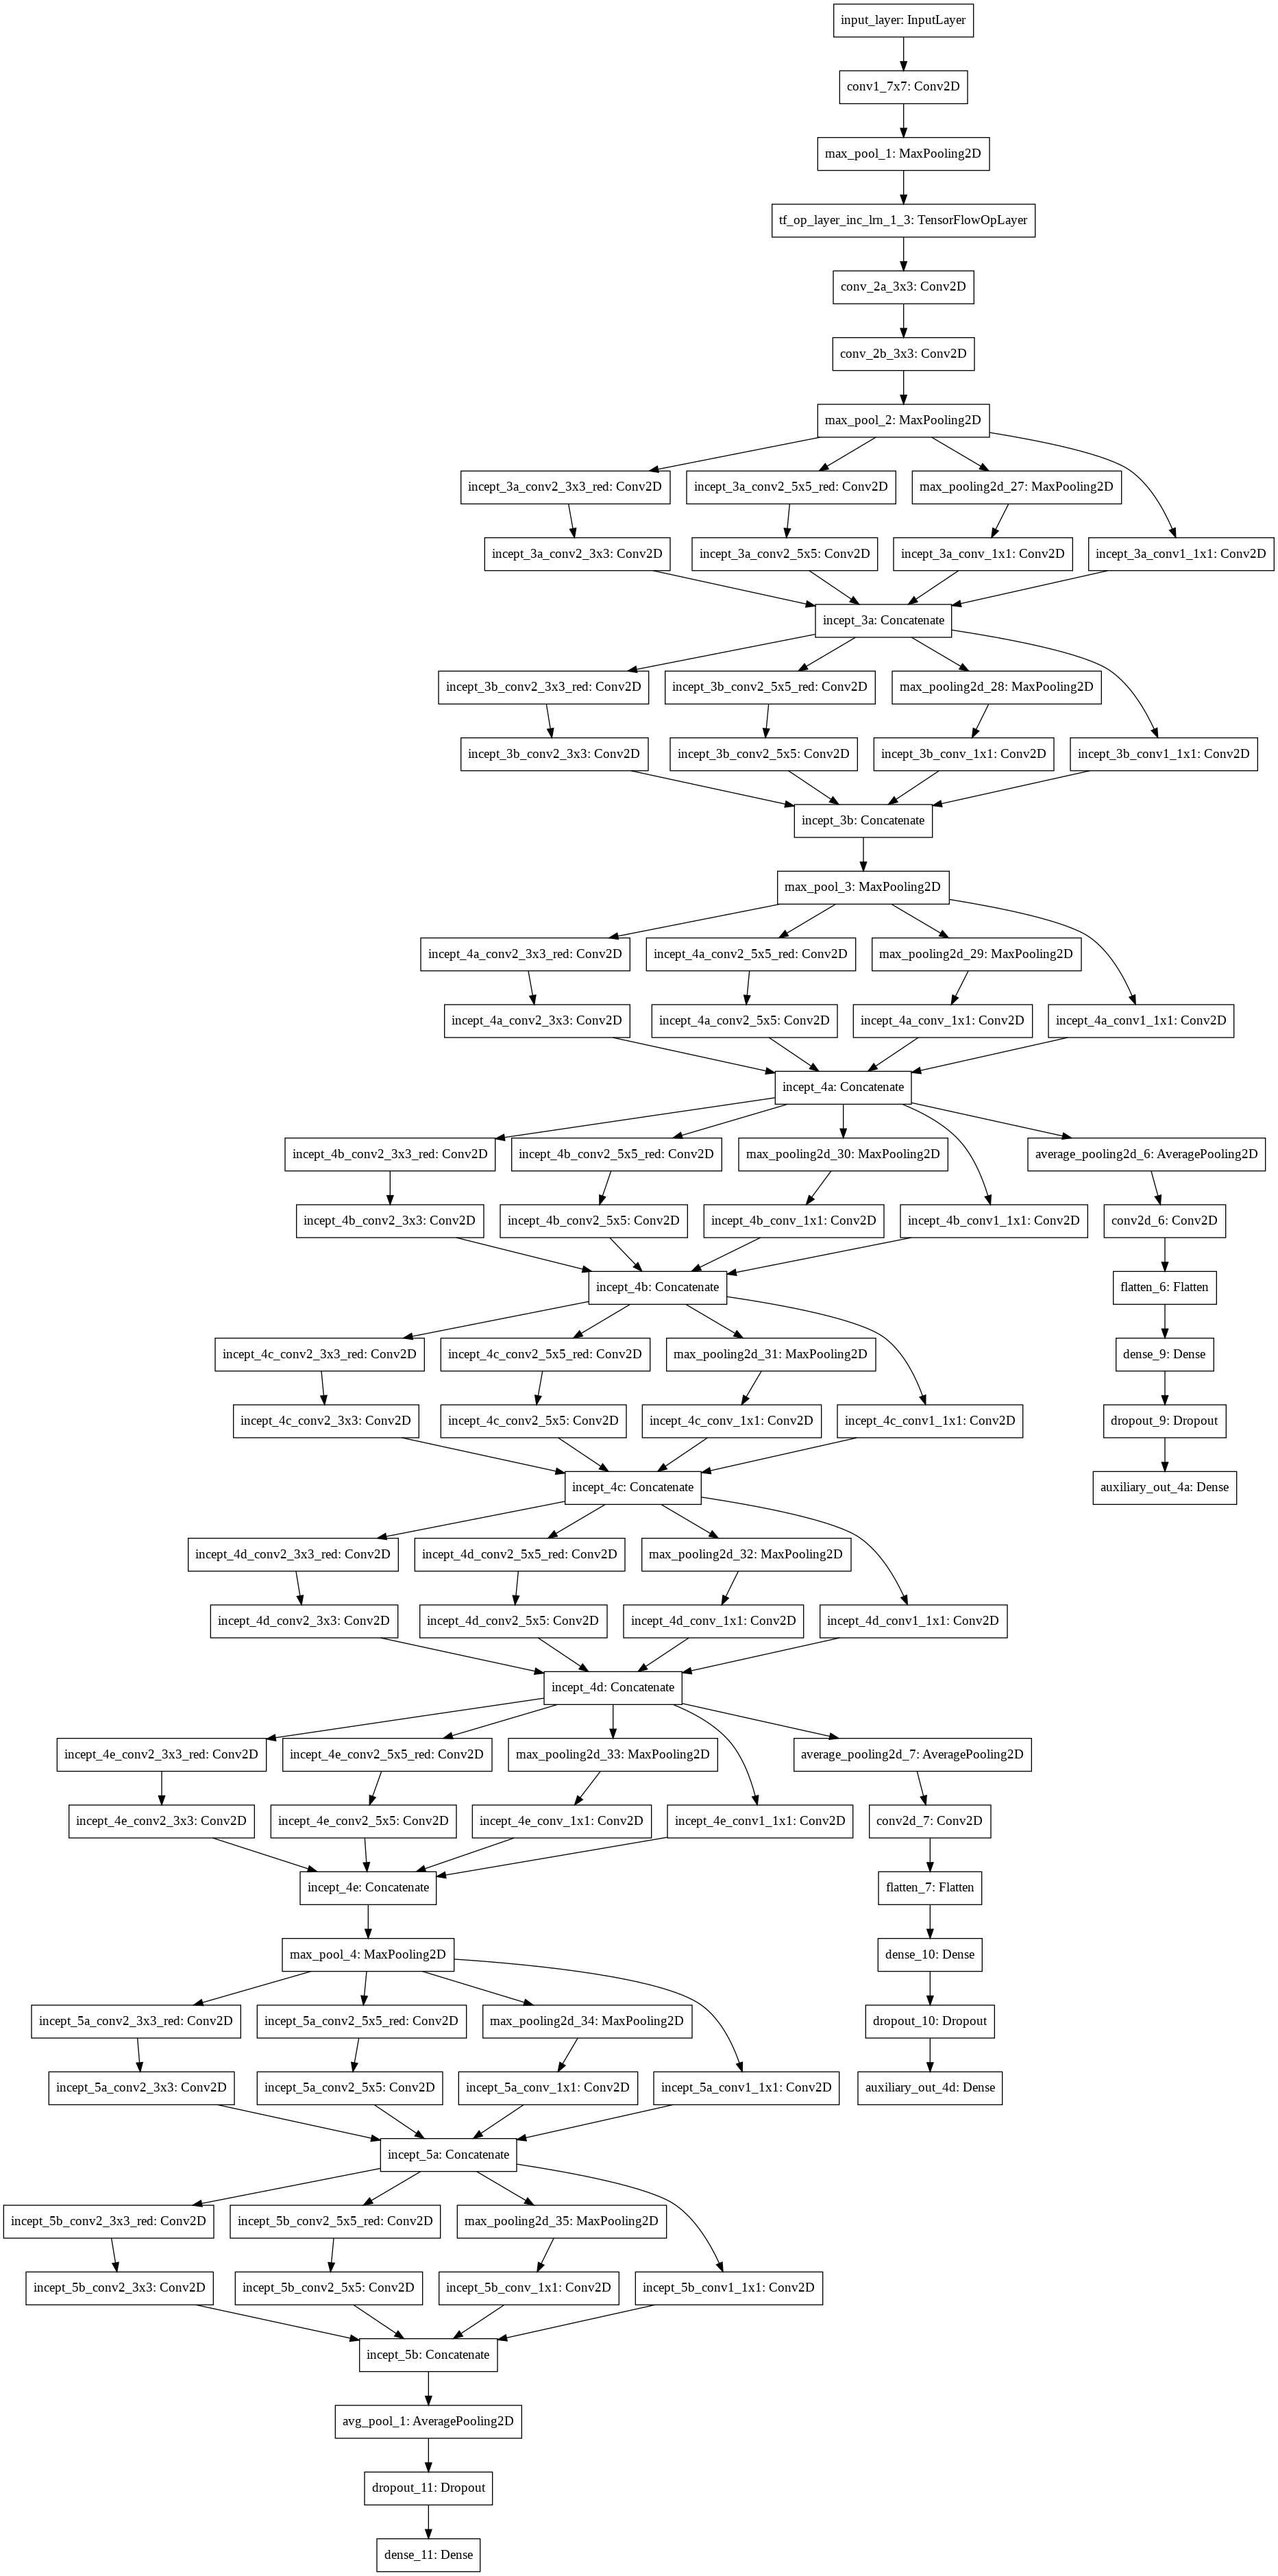

In [0]:
utils.plot_model(gn)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd drive/My\ Drive/

/content/drive/My Drive


In [0]:
import re
import os
import pickle

from PIL import Image

import numpy as np
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
        preprocess_input

from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, \
        Embedding, LSTM


from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.engine import training
from tensorflow.python.data.ops.dataset_ops import PrefetchDataset

from typing import List, Tuple
import tqdm
from tqdm import tqdm
import sys
import nltk
from nltk import bleu_score

In [0]:
def get_image_names(f_name: str) -> List:
    """Gets a list of image names

    Args:
        f_name: File name/Path

    Returns:
        img_names: List of image names
    """
    with open(f_name, 'r') as f:
        img_names = f.read().splitlines()

    img_names = ["./lab2/flickr8k/Flickr_Data/Images/" + name for name in img_names]

    # Sort the images and make sure that the list is unique
    img_names = sorted(set(img_names))

    return img_names

def get_all_captions(f_name: str) -> dict:
    """ Store all captions in a dictionary

    Args:
        f_name: Path of file containing all captions

    Returns:
        all_captions: Dictionary where keys are image names and values are
                      captions
    """
    with open(f_name, 'r') as f:
        caption_file = f.read().splitlines()

    # Store captions in a dictionary
    all_captions = {}

    for line in caption_file:
        name = re.search("^.*?jpg", line).group(0)
        caption = "<start> " +  re.search("\t(.*)", line).group(0)[1:] + " <end>"

        if name in all_captions.keys():
            all_captions[name].append(caption)
        else:
            all_captions[name] = [caption]

    return all_captions

In [0]:
def preprocess_image(img_path: str) -> Tuple[EagerTensor, str]:
    """Load and preprocess an image from path and preprocess

    Args:
        img_path: Image path

    Returns:
        img: The preprocessed image
    """
    # Read image from path as TensorFlow tensor
    img = tf.io.read_file(img_path)

    # Tell TensorFlow that the image is RGB
    img = tf.image.decode_jpeg(img, channels=3)

    # The default input shape of InceptionV3 is (299, 299, 3)
    img = tf.image.resize(img, (299, 299))

    # Default InceptionV3 image processing
    img = preprocess_input(img)

    return img, img_path

def extract_img_features(img_names: List, feat_extractor):
    """Extract features from list of images and store them in .npy matrices

    Args:
        img_names: List of image names
    """
    print("Starting image preprocessing...")
    # Check whether image needs preprocessing and feature extraction
    unprocessed_imgs = []
    for img in img_names:
        # The image might have been processed already
        if not os.path.isfile(img + ".npy"):
            unprocessed_imgs.append(img)

    # Only start preprocessing and feature extraction process if
    # unprocessed_imgs is not empty
    if unprocessed_imgs:
        # Create a data set from the images
        imgs = tf.data.Dataset.from_tensor_slices(unprocessed_imgs)

        # Preprocess each image in batches of 8
        img_batches = imgs.map(preprocess_image, num_parallel_calls=
                tf.data.experimental.AUTOTUNE).batch(8)

        for img, path in tqdm(img_batches):
            # Extract features for each batch of images
            batch_feat = feat_extractor(img)
            batch_feat = tf.reshape(batch_feat, (batch_feat.shape[0], -1,
            batch_feat.shape[3]))

            # Store the feature matrices in ./flickr8k/imgs/
            for bf, p in zip(batch_feat, path):
                feat_path = p.numpy().decode("utf-8")
                np.save(feat_path, bf.numpy())
    print(("Finished image preprocessing! "
        f"Processed {len(unprocessed_imgs)} images."))

def init_feat_extract_inception_v3() -> training.Model:
    """Initialize InceptionV3 as feature extraction model

    Returns:
        feat_extract_model: The feature extraction model based on weights
                            learnt on ImageNet
    """
    # Load the pretrained InceptionV3 network with weights from trianing on
    # ImageNet
    incv3 = InceptionV3(include_top=False, weights='imagenet')

    # Create a default model input
    model_input = incv3.input

    # We want the penultimate layer to be the last layer of our feature
    # extraction CNN. Note that the size of this layer is 8*8*2048.
    model_output = incv3.layers[-1].output

    # Define the feature extraction model
    feat_extract_model = Model(model_input, model_output)

    return feat_extract_model 

In [0]:
def preprocess_captions(img_names_training: List, all_captions:
        dict, k: int) -> Tuple[Tokenizer, np.ndarray]:
    """Preprocess all captions

    Args:
        img_names: Image names from the training data set
        all_captions: Captions of the complete data set
        k: Maximum number of words in our vocabulary

    Returns:
        tokenizer: The tokenizer fit on the captions of the training data set
        seqs: All tokenized captions in the training data set
    """
    # Split image names to remove everything from path except file name
    img_names = [img.split("/")[-1] for img in img_names_training]

    # Filter all_captions for the training set
    captions = {k: all_captions[k] for k in img_names if k in
            all_captions.keys()}

    # Extract all individual captions for the training set
    captions = [cap for img in img_names for cap in captions[img]]

    if os.path.isfile("./tokenizer.pkl"):
        # Load the tokenizer
        print("Loading tokenizer...")
        with open('tokenizer.pkl', 'rb') as f:
            tokenizer = pickle.load(f)
    else: 
        # Define the tokenizer
        tokenizer = Tokenizer(num_words=k, oov_token="<unk>",
                filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

        # Specificy word indexing
        tokenizer.word_index["<pad>"] = 0
        tokenizer.index_word[0] = "<pad>"

        # Fit the tokenizer on all captions in the training set
        print("Fitting tokenizer...")
        tokenizer.fit_on_texts(captions)

        # Save the tokenizer
        with open('tokenizer.pkl', 'wb') as f:
            print("Saving tokenizer...")
            pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

    # Create tokenized sequences for all captions
    seqs = tokenizer.texts_to_sequences(captions)

    # Pad the sequences s.t. they become of the same size
    seqs = pad_sequences(seqs, padding="post")

    return tokenizer, seqs

In [0]:
class Encoder(Model):
    """Subclass of tf.keras.Model: Encoder"""
    def __init__(self, embedding_dim: int):
        """Class constructor

        Args:
            embedding_dim: Dimensionality of the image embedding
        """
        super(Encoder, self).__init__()

        self.dense = Dense(embedding_dim, activation="relu")
        self.dropout = Dropout(0.5)
        self.b_norm = BatchNormalization()

    def call(self, x: tf.Tensor, training: bool=True):
        """Call function of the encoder model

        Args:
            x: Input tensor

        Returns:
            x: Output tensor
        """
        if training:
            x = self.dropout(x)

        x = self.dense(x)
        x = self.b_norm(x)

        # After the dense layer, the shape of x is: # (batch_size, 64,
        # embedding_dim). It should be of the same dimension as the text
        # embedding, which is (1, 1, embedding_dim)
        x = tf.expand_dims(tf.reduce_sum(x, axis=1), 1)

        return x

In [0]:
class Decoder(Model):
    """Subclass of tf.keras.Model: Decoder"""
    def __init__(self, embedding_dim: int, units: int, vocab_size: int):
        """Class constructor

        Args:
            embedding_dim: Dimensionality of the image embedding
            units:
            vocab_size:
        """
        super(Decoder, self).__init__()
        
        self.units = units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(units=units, return_sequences=True, return_state=True,
                name="lstm")
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, x, img_feats: tf.Tensor, lstm_state: List[tf.Tensor]=None,
            training: bool=True, time_step: int=0):
        """Call function of the encoder model

        Args:
            x: Input tensor
            img_feats: Feature embedding of the input image
            lstm_state: Initital state of the LSTM based on previous time step
            training: Whether the current phase is training
            it: Specify the current timestep
        
        Returns:
            x: Output tensor
        """
        x = self.embedding(x)

        # Only input the image features to the LSTM during the first pass
        if time_step == 0:
            _, h_state, c_state = self.lstm(img_feats)
            output, h_state, c_state = self.lstm(x,
                    initial_state=[h_state, c_state])
        else:
            output, h_state, c_state = self.lstm(x, initial_state=lstm_state)

        # Store the LSTM's hidden state and cell state in a list
        lstm_state = [h_state, c_state]

        # Because of return_sequences = True outut has three dimensions
        # (batch_size, time_step, output_units), which is needed since we are
        # stacking LSTMs. However, we want to return a 2D array of shape
        # (batch_Size, output_units)
        x = tf.reshape(output, (-1, output.shape[2]))

        # Pass the reshaped
        x = self.dense(x)

        return x, lstm_state

In [0]:
def load_img_features(img_name: str, cap: np.ndarray) -> Tuple[tf.Tensor,
        np.ndarray]:
    """Loads Numpy image features based on file name

    Args:
        img_name: Path to image file
        cap: Caption corresponding to image

    Returns:
        img: Tensor of image feature
        cap: Caption corresponding to image

    Note: We are passing cap, since this function is part of a lambda mapping
          function
    """
    img = np.load(img_name.decode("utf-8") + '.npy')

    return img, cap

def create_tf_dataset(img_names: List, seqs: np.ndarray, batch_size: int,
        buffer_size: int=8000):
    """Create a TensorFlow data set from a list of image names

    Args:
        img_names: List of image names
        seqs: Array of tokenized sequences corresponding to captions
        batch_size: Batch size

    Returns:
        dataset: TensorFlow data set partioned in batches of batch_size
    """
    # Create dataset form tensors
    dataset = tf.data.Dataset.from_tensor_slices((img_names, seqs))

    # Load the numpy files into the dataset
    dataset = dataset.map(lambda img, cap: tf.numpy_function(
        load_img_features, [img, cap], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle the data set and create batches of size batch_size
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

def loss_function(real: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """Define the loss function

    Args:
        real: Real caption
        pred: Predicted caption

    Returns:
        loss: Loss
    """
    objective = SparseCategoricalCrossentropy(from_logits=True, reduction="none")

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = objective(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_mean(loss)

    return loss

@tf.function
def train_step(img, cap, encoder, decoder, optimizer, tokenizer):
    """Perform a single training step

    Args:
        img: Input image
        cap: Input (target) caption
        encoder: Encoder model
        decoder: Decoder model
        optimizer: Optimizer
        tokenizer: Tokenizer

    Returns:
        batch_loss: Batch loss
        total_loss: Total loss
    """
    batch_loss = 0

    # Define the decoder input -- tokenizer target caption
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] *
            cap.shape[0], 1)

    with tf.GradientTape() as tape:
        # Encode the image
        img_feats = encoder(img, training=True)

        # At the start the LSTM doesn't have a state yet
        lstm_state = None

        for i in range(1, cap.shape[1]):
            preds, lstm_state = decoder(dec_input, img_feats, lstm_state,
                    training=True, time_step=i-1)

            batch_loss += loss_function(cap[:, i], preds)

            dec_input = tf.expand_dims(cap[:, i], axis=1)

    total_loss = (batch_loss / int(cap.shape[1]))

    # Identify all trainable variables
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables

    # Compute the gradients of the trainable variables
    gradients = tape.gradient(batch_loss, trainable_vars)

    # Apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return batch_loss, total_loss


def train(dataset: PrefetchDataset, epochs: int, encoder: Encoder,
        decoder: Decoder, optimizer: Adam, tokenizer: Tokenizer,
        num_steps: float):
    """Train the image captioning model

    Args:
        dataset: Training data set
        epochs: Number of training epochs
        encoder: Encoder model
        decoder: Decoder model
        optimizer: Optimizer
        tokenizer: Tokenizer
        num_steps: Number of training steps
    """
    ckpt_path = "./checkpoints"

    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)

    # Create a checkpoint
    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder,
            optimizer=optimizer)

    # Pass the checkpoint to the checkpoint manager
    ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

    start_epoch = 0
    if ckpt_manager.latest_checkpoint:
        print("Loading checkpoint...")
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        ckpt.restore(ckpt_manager.latest_checkpoint)#.assert_consumed()
        print("Latest checkpoint restored!")

    print(f"Start epoch: {start_epoch}")
    for epoch in range(start_epoch, epochs):
        total_loss = 0

        for (batch, (img, cap)) in enumerate(dataset):
            batch_loss, t_loss = train_step(img, cap, encoder, decoder,
                    optimizer, tokenizer)
            total_loss += t_loss

        print("Saving a checkpoint...")
        ckpt_manager.save(checkpoint_number=epoch)

        print("Epoch {} - Loss {:.6f}".format(epoch + 1, total_loss/num_steps))

In [0]:
def evaluate(img: str, feat_extract_model: training.Model,
        tokenizer: Tokenizer, encoder: Encoder, decoder: Decoder,
        max_length: int=20, eval_type: str="beam", beam_size=1):
    """Predict a caption for a specific image using naive sequence sampling

    Args:
        img: Name of input image for evaluation
        feat_extract_model: Image feature extraction model
        tokenizer: Tokenizer
        encoder: Encoder model
        decoder: Decoder model
        max_length: Maximum length of the resulting caption
        eval_type: Either 'beam' or 'greedy' to specify the type of evaluation
        beam_size: Size of the beam if eval_type=='beam"

    Return:
        caption: Final caption
    """
    img = tf.expand_dims(preprocess_image(img)[0], 0)
    img = feat_extract_model(img)
    img = tf.reshape(img, (img.shape[0], -1,
        img.shape[3]))

    # Encode the image to extract features
    img_feats = encoder(img)

    if eval_type == "greedy":
        print("Starting greedy search...")
        # Define the initial decoder input
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

        # The LSTM does not have a state at first
        lstm_state = None

        caption = []
        for i in range(max_length):
            # Predict next word id using :STM
            predictions, lstm_state = decoder(dec_input, img_feats, lstm_state,
                    time_step=i)

            # Predcict the id
            predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
            caption.append(tokenizer.index_word[predicted_id])

            if tokenizer.index_word[predicted_id] == '<end>':
                return " ".join(caption[:-1])

            dec_input = tf.expand_dims([predicted_id], 0)

        caption = " ".join(caption[:-1])
      
    elif eval_type == "beam":
        print(f"Starting beam search with beam size {beam_size}...")
        # Initialize the result (ids, decoder input, probability, lstm state)
        cap = [tokenizer.word_index["<start>"]]
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
        lstm_state = None
        prob = 0.0

        result = [[cap, dec_input, prob, lstm_state]]

        for i in range(max_length):
            # Track a temporary result
            temp_res = []

            # Iterate over each word in the current result
            for r in result:
                dec_input, lstm_state = r[1], r[3]
                predictions, lstm_state = decoder(dec_input, img_feats,
                        lstm_state, time_step=i)

                # Obtain the indices of the top-beamsize predictions
                predicted_ids = predictions[0].numpy().argsort() \
                        [-beam_size:][::-1]

                # Loop over all predicted ids
                for i in predicted_ids:
                    # Obtain the current partial caption and probability
                    cap, prob = r[0][:], r[2]

                    # Add the index to the current partial capption
                    cap.append(i)
                    # Add the probability of i to prob
                    prob += predictions[0].numpy()[i]

                    # Add the updated partial caption and probability to the
                    # temporary result
                    dec_input = tf.expand_dims([i], 0)
                    temp_res.append([cap, dec_input, prob, lstm_state])

            # Update result by the temporary result
            result = temp_res

            # Sort the result based on the probabilities and only keep the
            # top-beamsize partial captions
            result = sorted(result, reverse=True, key=lambda l: l[2])
            result = result[:beam_size]

        # Obtain the final best result
        caption = result[0][0]

        caption = [tokenizer.index_word[i] for i in caption][1:]
        caption = " ".join(caption)

        try:
            caption = caption.split("<end>", 1)[:-1][0][:-1]
        except:
            pass
    else:
        raise ValueError("Input argument <eval_type> has to be either " +
                  "'beam' or 'greedy'")

    return caption  

In [16]:
batch_size = 64

# Get the train image names
train_image_names = get_image_names(
        "./lab2/flickr8k/Flickr_Data/text/Flickr_8k.trainImages.txt")

# Initialize the feature extraction model (InceptionV3)
feat_extract_model = init_feat_extract_inception_v3()

# Extract features from the images
extract_img_features(train_image_names, feat_extractor=feat_extract_model)

# Get captions in the whole data set
all_captions = get_all_captions("./lab2/flickr8k/Flickr_Data/text/Flickr8k.token.txt")

# Fit a tokenizer on the training data with vocabulary of length k and
# find a tokenized sequences for each caption in the training data set
tokenizer, train_seqs = preprocess_captions(train_image_names,
        all_captions, k=5000)

# Duplicate each image name 5 times
train_image_names = [name for name in train_image_names
        for _ in range(5)]

# Create TensorFlow dataset
dataset = create_tf_dataset(train_image_names, train_seqs,
        batch_size=batch_size)

# Initialize the encoder and decoder
encoder = Encoder(embedding_dim=256)
decoder = Decoder(embedding_dim=256, units=512,
        vocab_size=len(tokenizer.word_index)+1)

# Instantiate the optimizer
optimizer = Adam()

# Calculate number of training steps
num_steps = len(train_image_names) / batch_size

# Train the model for 50 epochs
# train(dataset, 50, encoder, decoder, optimizer, tokenizer, num_steps)

87916544/87910968 [==============================] - 2s 0us/step
Starting image preprocessing...


1it [00:00,  1.05it/s]


Finished image preprocessing! Processed 1 images.
Loading tokenizer...


In [0]:
# Based on the official tutorial: https://www.nltk.org/_modules/nltk/translate/bleu_score.html

def compute_bleu_score(predicted_output, true_output, n_grams="3-gram"):
    if n_grams == "1-gram":
        weights = [1.0]
    elif n_grams == "2-gram":
        weights = [1./2., 1./2.]
    elif n_grams == "3-gram":
        weights = [1./3., 1./3., 1./3.]
    elif n_grams == "4-gram":
        weights = [1./4., 1./4., 1./4., 1./4.]
    else:
        print("Provide an accepted mode. Choose from: 1-gram, 2-gram, 3-gram, 4-gram.")
        sys.exit()
        
    return bleu_score.sentence_bleu([predicted_output], true_output, weights=weights)



Loading tokenizer...
Loaded tokenizer!
Loading checkpoint...
Latest checkpoint restored!
Starting beam search with beam size 1...
Caption: a man riding a truck on the street


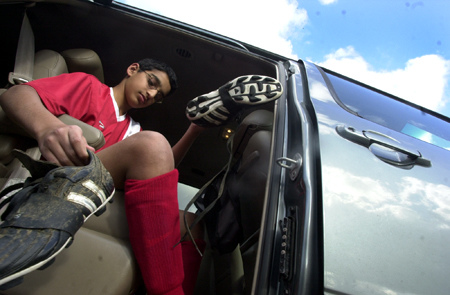

Starting beam search with beam size 1...
Caption: a man on a sled pulled by a dog sled


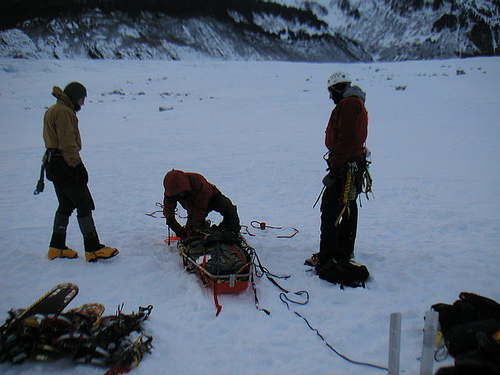

Starting beam search with beam size 1...
Caption: a man with a beard with a beard in a white shirt and baseball


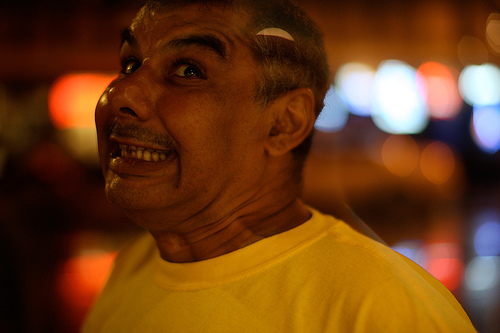

Starting beam search with beam size 1...
Caption: a woman and child are playing in the sand


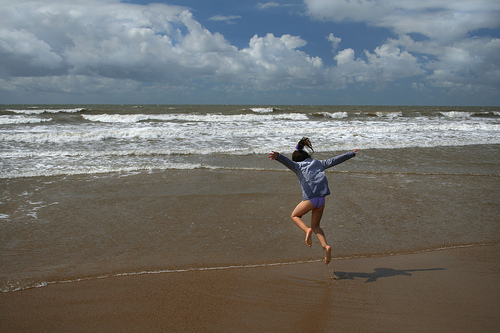

Starting beam search with beam size 1...
Caption: several people are walking down a city street in the background


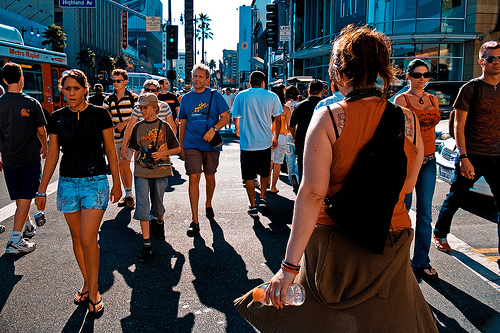

Starting beam search with beam size 1...
Caption: a little girl in a pink shirt runs in the grass


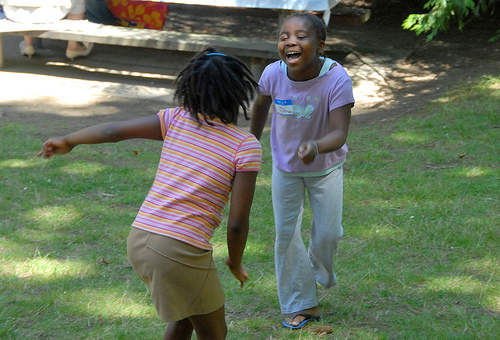

Starting beam search with beam size 1...
Caption: a boy plays with his mouth open while the woman on the left


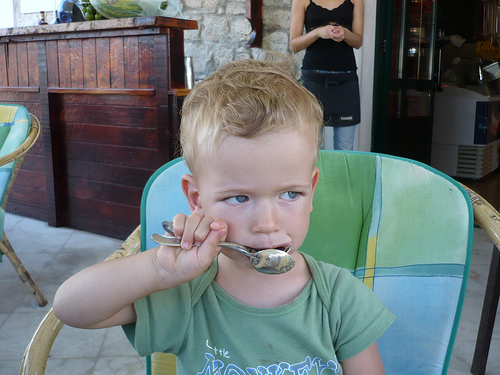

Starting beam search with beam size 1...
Caption: a little girl in a white shirt has been <unk> with arms stretched out to her sides


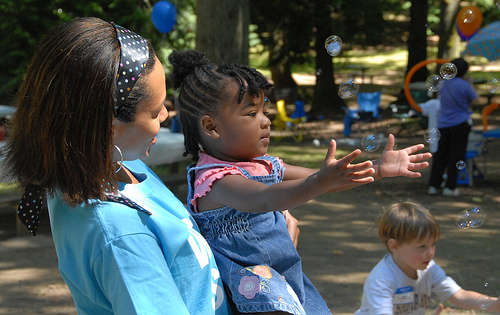

Starting beam search with beam size 1...
Caption: a young girl wearing a pink hat is walking in the sand


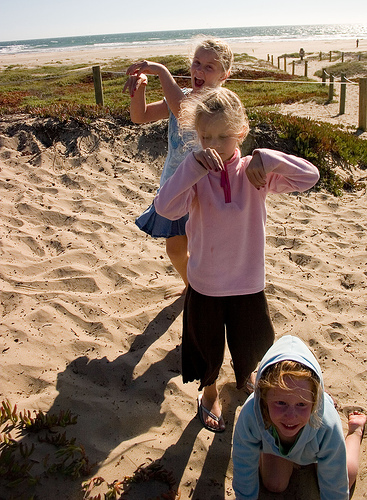

In [18]:
# Suppress warnings
tf.get_logger().setLevel('ERROR')

# Get the test image names
test_image_names = get_image_names(
        "./lab2/flickr8k/Flickr_Data/text/Flickr_8k.testImages.txt")

# Initialize the feature extraction model (InceptionV3)
feat_extract_model = init_feat_extract_inception_v3()

print("Loading tokenizer...")
with open('./lab2/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("Loaded tokenizer!")

# Initialize the encoder and decoder
encoder = Encoder(embedding_dim=256)
decoder = Decoder(embedding_dim=256, units=512,
        vocab_size=len(tokenizer.word_index)+1)

# Instantiate the optimizer
optimizer = Adam()

# Load the latest checkpoint
ckpt_path = "./lab2/checkpoints"

# Create a checkpoint
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder,
        optimizer=optimizer)

# Pass the checkpoint to the checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    print("Loading checkpoint...")
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

for i in range(11, 20):
    # Evaluate the model
    caption = evaluate(test_image_names[i], feat_extract_model, tokenizer,
            encoder, decoder)

    # Print the predicted caption
    print(f"Caption: {caption}")
    display(Image.open(test_image_names[i]))
    

In [41]:
# Suppress warnings
tf.get_logger().setLevel('ERROR')

# Get the test image names
test_image_names = get_image_names(
        "./lab2/flickr8k/Flickr_Data/text/Flickr_8k.testImages.txt")

# Initialize the feature extraction model (InceptionV3)
feat_extract_model = init_feat_extract_inception_v3()

print("Loading tokenizer...")
with open('./lab2/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("Loaded tokenizer!")

# Initialize the encoder and decoder
encoder = Encoder(embedding_dim=256)
decoder = Decoder(embedding_dim=256, units=512,
        vocab_size=len(tokenizer.word_index)+1)

# Instantiate the optimizer
optimizer = Adam()

# Load the latest checkpoint
ckpt_path = "./lab2/checkpoints"

# Create a checkpoint
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder,
        optimizer=optimizer)

# Pass the checkpoint to the checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    print("Loading checkpoint...")
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

bleu_score_1_list = []
bleu_score_2_list = []
bleu_score_3_list = []
bleu_score_4_list = []
predicted_captions =[]
true_captions = []

# Get captions in the whole data set
all_captions = get_all_captions("./lab2/flickr8k/Flickr_Data/text/Flickr8k.token.txt")

# print(len(all_captions))
# print(len(test_image_names))
# print(test_image_names[999])
# print(test_image_names)


for img_path, cap in tqdm(zip(test_image_names, all_captions), total=len(test_image_names)):
  
  if os.path.exists(img_path):
    # Evaluate the model
    caption = evaluate(img_path, feat_extract_model, tokenizer,
            encoder, decoder)
    # print(caption)
    predicted_captions.append(caption)
    true_captions.append(cap)

  else:
    raise Exception('Image path does not exist.')
  
  output_df = {"predicted": [], "true": []}

  for i in range(len(predicted_captions)):
        output_df["predicted"].append(predicted_captions[i])
        output_df["true"].append(true_captions[i])
        blue_1 = compute_bleu_score(predicted_captions[i], true_captions[i], n_grams="1-gram")
        bleu_score_1_list.append(blue_1)

  bleu_score1 = np.mean(bleu_score_1_list)
  print("1-gram bleu score on test dataset is : ", bleu_score1)







  0%|          | 0/1000 [00:00<?, ?it/s]

Loading tokenizer...
Loaded tokenizer!
Loading checkpoint...
Latest checkpoint restored!
Starting beam search with beam size 1...






  0%|          | 1/1000 [00:00<11:42,  1.42it/s]

1-gram bleu score on test dataset is :  0.07189263425875544






  0%|          | 2/1000 [00:01<10:19,  1.61it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.06264360048602799






  0%|          | 3/1000 [00:01<09:19,  1.78it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.053388025854578795






  0%|          | 4/1000 [00:01<08:43,  1.90it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.048590814173138805






  0%|          | 5/1000 [00:02<08:15,  2.01it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.044923533697335497






  1%|          | 6/1000 [00:02<07:58,  2.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.044156968068329305






  1%|          | 7/1000 [00:03<07:41,  2.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04599967359912503






  1%|          | 8/1000 [00:03<07:41,  2.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.046922631986259254






  1%|          | 9/1000 [00:04<07:37,  2.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04663603063938685






  1%|          | 10/1000 [00:04<07:30,  2.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04588161734778445






  1%|          | 11/1000 [00:05<07:27,  2.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04549517129617067






  1%|          | 12/1000 [00:05<07:23,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.045695881227454355






  1%|▏         | 13/1000 [00:06<07:26,  2.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04590548439145348






  1%|▏         | 14/1000 [00:06<07:20,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.045714252703336934






  2%|▏         | 15/1000 [00:06<07:18,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04589133979937816






  2%|▏         | 16/1000 [00:07<07:17,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04594793323465245






  2%|▏         | 17/1000 [00:07<07:13,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.046125766861236206






  2%|▏         | 18/1000 [00:08<07:20,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.046177573291578795






  2%|▏         | 19/1000 [00:08<07:15,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0460193182762529






  2%|▏         | 20/1000 [00:09<07:18,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04595554481648571






  2%|▏         | 21/1000 [00:09<07:15,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04618738771691478






  2%|▏         | 22/1000 [00:09<07:13,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04654987727999656






  2%|▏         | 23/1000 [00:10<07:09,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04678984529910829






  2%|▏         | 24/1000 [00:10<07:06,  2.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0472905542831248






  2%|▎         | 25/1000 [00:11<07:10,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04785147297703631






  3%|▎         | 26/1000 [00:11<07:10,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04843932282047019






  3%|▎         | 27/1000 [00:12<07:12,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0489235346072466






  3%|▎         | 28/1000 [00:12<07:11,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.04933614606680865






  3%|▎         | 29/1000 [00:13<07:10,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.049831092167622514






  3%|▎         | 30/1000 [00:13<07:15,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.050239507292828924






  3%|▎         | 31/1000 [00:13<07:11,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05057919841477355






  3%|▎         | 32/1000 [00:14<07:12,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05083975098001463






  3%|▎         | 33/1000 [00:14<07:14,  2.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.051037388750703315






  3%|▎         | 34/1000 [00:15<07:16,  2.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0512695643437168






  4%|▎         | 35/1000 [00:15<07:11,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.051533245022741724






  4%|▎         | 36/1000 [00:16<07:07,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.051766174014331624






  4%|▎         | 37/1000 [00:16<07:07,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.051988424302302196






  4%|▍         | 38/1000 [00:17<07:09,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05215831432868923






  4%|▍         | 39/1000 [00:17<07:11,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05227714145996937






  4%|▍         | 40/1000 [00:18<07:08,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05235685536056887






  4%|▍         | 41/1000 [00:18<07:11,  2.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05244405158127928






  4%|▍         | 42/1000 [00:18<07:09,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.052553749088921846






  4%|▍         | 43/1000 [00:19<07:11,  2.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.052633113188209235






  4%|▍         | 44/1000 [00:19<07:10,  2.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05269727342713935






  4%|▍         | 45/1000 [00:20<07:09,  2.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.052723991330252025






  5%|▍         | 46/1000 [00:20<07:06,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05272839793480137






  5%|▍         | 47/1000 [00:21<07:05,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05270489268931522






  5%|▍         | 48/1000 [00:21<07:07,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05276990517060783






  5%|▍         | 49/1000 [00:22<07:02,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05281042935915243






  5%|▌         | 50/1000 [00:22<06:59,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05282944149302071






  5%|▌         | 51/1000 [00:22<07:02,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05283252007061329






  5%|▌         | 52/1000 [00:23<07:01,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.052810783413903925






  5%|▌         | 53/1000 [00:23<06:54,  2.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0527647248419166






  5%|▌         | 54/1000 [00:24<06:55,  2.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05269374395681123






  6%|▌         | 55/1000 [00:24<06:55,  2.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05269462788886019






  6%|▌         | 56/1000 [00:25<06:56,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.052712558973574374






  6%|▌         | 57/1000 [00:25<06:55,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05272117990243751






  6%|▌         | 58/1000 [00:25<06:50,  2.30it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05276854274437971






  6%|▌         | 59/1000 [00:26<06:50,  2.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.052794780506716994






  6%|▌         | 60/1000 [00:26<06:48,  2.30it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05287306180679541






  6%|▌         | 61/1000 [00:27<06:48,  2.30it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0529347866328655






  6%|▌         | 62/1000 [00:27<06:45,  2.31it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05299636394339179






  6%|▋         | 63/1000 [00:28<06:49,  2.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05304586868486895






  6%|▋         | 64/1000 [00:28<06:48,  2.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05311961830921453






  6%|▋         | 65/1000 [00:29<06:46,  2.30it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0531802097297908






  7%|▋         | 66/1000 [00:29<06:51,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05324655945967762






  7%|▋         | 67/1000 [00:29<06:48,  2.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05331062279296616






  7%|▋         | 68/1000 [00:30<06:48,  2.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05336368192021997






  7%|▋         | 69/1000 [00:30<06:50,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05343194505113341






  7%|▋         | 70/1000 [00:31<06:48,  2.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.053478773426538534






  7%|▋         | 71/1000 [00:31<06:51,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.053522401083227096






  7%|▋         | 72/1000 [00:32<06:48,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.053578678930797936






  7%|▋         | 73/1000 [00:32<06:49,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.053644787248214226






  7%|▋         | 74/1000 [00:33<06:47,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.053710863991207725






  8%|▊         | 75/1000 [00:33<06:48,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05379911670336521






  8%|▊         | 76/1000 [00:33<06:52,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0539106768140597






  8%|▊         | 77/1000 [00:34<06:49,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.054026350797409216






  8%|▊         | 78/1000 [00:34<06:48,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.054128887308809034






  8%|▊         | 79/1000 [00:35<06:49,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05422792893152133






  8%|▊         | 80/1000 [00:35<06:46,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05433039128628167






  8%|▊         | 81/1000 [00:36<06:41,  2.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05442924366499069






  8%|▊         | 82/1000 [00:36<06:40,  2.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05453531940728497






  8%|▊         | 83/1000 [00:36<06:45,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05464452732555473






  8%|▊         | 84/1000 [00:37<06:46,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05476719270851812






  8%|▊         | 85/1000 [00:37<06:45,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05487985604990764






  9%|▊         | 86/1000 [00:38<06:43,  2.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05497976946739657






  9%|▊         | 87/1000 [00:38<06:45,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05507884233086531






  9%|▉         | 88/1000 [00:39<06:45,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.055179158242621096






  9%|▉         | 89/1000 [00:39<06:49,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.055276172248740034






  9%|▉         | 90/1000 [00:40<06:52,  2.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05536380243644283






  9%|▉         | 91/1000 [00:40<06:48,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.055441630835982046






  9%|▉         | 92/1000 [00:41<06:46,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.055518112274525716






  9%|▉         | 93/1000 [00:41<06:40,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05558559072883793






  9%|▉         | 94/1000 [00:41<06:42,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05566355103984521






 10%|▉         | 95/1000 [00:42<06:40,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05574051559350841






 10%|▉         | 96/1000 [00:42<06:41,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05580425495544607






 10%|▉         | 97/1000 [00:43<06:40,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.055872893854182884






 10%|▉         | 98/1000 [00:43<06:44,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05593492192647503






 10%|▉         | 99/1000 [00:44<06:41,  2.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05599083969355931






 10%|█         | 100/1000 [00:44<06:38,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05604034313011078






 10%|█         | 101/1000 [00:45<06:38,  2.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056090342500225626






 10%|█         | 102/1000 [00:45<06:38,  2.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05613093213705712






 10%|█         | 103/1000 [00:45<06:42,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056176144333709176






 10%|█         | 104/1000 [00:46<06:42,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05622261989404448






 10%|█         | 105/1000 [00:46<06:45,  2.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05626738384470869






 11%|█         | 106/1000 [00:47<06:40,  2.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056304809223607435






 11%|█         | 107/1000 [00:48<08:09,  1.82it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0563416319067905






 11%|█         | 108/1000 [00:48<09:35,  1.55it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05637305049956189






 11%|█         | 109/1000 [00:49<09:56,  1.49it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056395415204802804






 11%|█         | 110/1000 [00:50<10:54,  1.36it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05641693252029575






 11%|█         | 111/1000 [00:51<11:05,  1.33it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056436677881106734






 11%|█         | 112/1000 [00:52<11:35,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056458320234165006






 11%|█▏        | 113/1000 [00:53<11:50,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05648074467326532






 11%|█▏        | 114/1000 [00:53<11:27,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056496156504121






 12%|█▏        | 115/1000 [00:54<11:22,  1.30it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05650625926355694






 12%|█▏        | 116/1000 [00:55<11:38,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05651184764860429






 12%|█▏        | 117/1000 [00:56<11:53,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05651409142475524






 12%|█▏        | 118/1000 [00:57<12:25,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05650997248614343






 12%|█▏        | 119/1000 [00:57<12:10,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05650685683214524






 12%|█▏        | 120/1000 [00:58<11:43,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05649790601293607






 12%|█▏        | 121/1000 [00:59<11:47,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05648368764048278






 12%|█▏        | 122/1000 [01:00<11:28,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05646833070278067






 12%|█▏        | 123/1000 [01:00<11:21,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05644923939597204






 12%|█▏        | 124/1000 [01:01<11:16,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05642441434992479






 12%|█▎        | 125/1000 [01:02<11:32,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056405685140383605






 13%|█▎        | 126/1000 [01:03<11:44,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05639095749384491






 13%|█▎        | 127/1000 [01:04<11:52,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05637535173150371






 13%|█▎        | 128/1000 [01:05<12:03,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056361063702756335






 13%|█▎        | 129/1000 [01:05<11:31,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056363423196588235






 13%|█▎        | 130/1000 [01:06<11:58,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05636342561545044






 13%|█▎        | 131/1000 [01:07<11:31,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056361653711935716






 13%|█▎        | 132/1000 [01:08<11:43,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05636068319664129






 13%|█▎        | 133/1000 [01:09<11:46,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05635529624643213






 13%|█▎        | 134/1000 [01:10<12:12,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056347833710251594






 14%|█▎        | 135/1000 [01:10<11:37,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05633792467208948






 14%|█▎        | 136/1000 [01:11<11:56,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05632414490186697






 14%|█▎        | 137/1000 [01:12<11:36,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05630993065546628






 14%|█▍        | 138/1000 [01:13<11:24,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05630391116535766






 14%|█▍        | 139/1000 [01:14<11:47,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056301512361828496






 14%|█▍        | 140/1000 [01:14<11:25,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056295772991672176






 14%|█▍        | 141/1000 [01:15<11:37,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05629723318208291






 14%|█▍        | 142/1000 [01:16<11:46,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056297489344226556






 14%|█▍        | 143/1000 [01:17<11:31,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05630302944829048






 14%|█▍        | 144/1000 [01:18<11:27,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05630609476278748






 14%|█▍        | 145/1000 [01:19<12:22,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0563061812616534






 15%|█▍        | 146/1000 [01:19<12:16,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0563060430026461






 15%|█▍        | 147/1000 [01:20<12:10,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05630605286925695






 15%|█▍        | 148/1000 [01:21<12:19,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05630584602193479






 15%|█▍        | 149/1000 [01:22<11:46,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056302118691225






 15%|█▌        | 150/1000 [01:23<11:25,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056298932251763446






 15%|█▌        | 151/1000 [01:24<12:13,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056292872429864714






 15%|█▌        | 152/1000 [01:24<12:18,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05629110851335683






 15%|█▌        | 153/1000 [01:27<17:59,  1.27s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056289840774804166






 15%|█▌        | 154/1000 [01:28<16:09,  1.15s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05628547151967002






 16%|█▌        | 155/1000 [01:28<14:49,  1.05s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05628906102190627






 16%|█▌        | 156/1000 [01:29<13:55,  1.01it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056296925955385484






 16%|█▌        | 157/1000 [01:30<13:26,  1.05it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056306084062646526






 16%|█▌        | 158/1000 [01:31<13:03,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0563207844353615






 16%|█▌        | 159/1000 [01:32<12:49,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056333067398255096






 16%|█▌        | 160/1000 [01:33<12:15,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05634616088939642






 16%|█▌        | 161/1000 [01:34<12:19,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05636245260790757






 16%|█▌        | 162/1000 [01:35<13:20,  1.05it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05637893765082925






 16%|█▋        | 163/1000 [01:35<12:07,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056400928166424724






 16%|█▋        | 164/1000 [01:36<11:54,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05642091056697032






 16%|█▋        | 165/1000 [01:37<11:49,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056441685533223464






 17%|█▋        | 166/1000 [01:38<11:37,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05646028637304787






 17%|█▋        | 167/1000 [01:39<11:41,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05647596384256215






 17%|█▋        | 168/1000 [01:40<12:29,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05649055463686795






 17%|█▋        | 169/1000 [01:40<12:00,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056502919374993854






 17%|█▋        | 170/1000 [01:41<11:57,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05651550615393249






 17%|█▋        | 171/1000 [01:42<11:36,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05653031826182733






 17%|█▋        | 172/1000 [01:43<11:42,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056544228380384635






 17%|█▋        | 173/1000 [01:44<11:54,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056556018183747676






 17%|█▋        | 174/1000 [01:45<11:28,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056573921565456445






 18%|█▊        | 175/1000 [01:45<11:01,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05658925711621022






 18%|█▊        | 176/1000 [01:46<11:13,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05660766086751535






 18%|█▊        | 177/1000 [01:47<11:14,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05662347075091964






 18%|█▊        | 178/1000 [01:48<11:55,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0566369482581461






 18%|█▊        | 179/1000 [01:49<11:43,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05665016531602095






 18%|█▊        | 180/1000 [01:50<11:56,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056664249147813546






 18%|█▊        | 181/1000 [01:51<11:36,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056675781783242264






 18%|█▊        | 182/1000 [01:51<11:34,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05668428434411542






 18%|█▊        | 183/1000 [01:52<11:59,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056698008507290724






 18%|█▊        | 184/1000 [01:53<11:58,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05671000344993059






 18%|█▊        | 185/1000 [01:54<11:47,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05672073825754845






 19%|█▊        | 186/1000 [01:55<11:13,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05672989059613352






 19%|█▊        | 187/1000 [01:56<11:05,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056738221055791495






 19%|█▉        | 188/1000 [01:57<12:42,  1.07it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05674421270363271






 19%|█▉        | 189/1000 [01:58<12:12,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056749376864367304






 19%|█▉        | 190/1000 [01:58<11:39,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05675694117174798






 19%|█▉        | 191/1000 [01:59<11:16,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056765547000562945






 19%|█▉        | 192/1000 [02:00<10:57,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05677449305425013






 19%|█▉        | 193/1000 [02:01<11:04,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678491291478796






 19%|█▉        | 194/1000 [02:02<11:28,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679316615981662






 20%|█▉        | 195/1000 [02:03<11:32,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679927677861066






 20%|█▉        | 196/1000 [02:03<11:33,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05680449848647097






 20%|█▉        | 197/1000 [02:04<11:40,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05680768526335552






 20%|█▉        | 198/1000 [02:05<11:41,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05681247094139682






 20%|█▉        | 199/1000 [02:06<11:36,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056819695756234204






 20%|██        | 200/1000 [02:07<11:33,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056825857525652






 20%|██        | 201/1000 [02:08<11:31,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056832076729297396






 20%|██        | 202/1000 [02:09<11:38,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05683922110169424






 20%|██        | 203/1000 [02:10<12:00,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05684932078688499






 20%|██        | 204/1000 [02:11<12:06,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0568590837711209






 20%|██        | 205/1000 [02:11<11:28,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056871467247973824






 21%|██        | 206/1000 [02:12<11:18,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05688166977045568






 21%|██        | 207/1000 [02:13<11:19,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05688940947935356






 21%|██        | 208/1000 [02:14<10:53,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056896352508606945






 21%|██        | 209/1000 [02:15<10:51,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05690314794858744






 21%|██        | 210/1000 [02:15<10:48,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05690803621247475






 21%|██        | 211/1000 [02:17<12:26,  1.06it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05691260857463668






 21%|██        | 212/1000 [02:18<11:59,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056920754705398355






 21%|██▏       | 213/1000 [02:18<11:42,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0569319991670895






 21%|██▏       | 214/1000 [02:19<11:08,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05694318839361469






 22%|██▏       | 215/1000 [02:21<14:01,  1.07s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05695412090926408






 22%|██▏       | 216/1000 [02:22<14:31,  1.11s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05696425592706165






 22%|██▏       | 217/1000 [02:23<13:22,  1.03s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05697447221878861






 22%|██▏       | 218/1000 [02:24<14:39,  1.13s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0569828582539791






 22%|██▏       | 219/1000 [02:25<13:21,  1.03s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056989053103250795






 22%|██▏       | 220/1000 [02:26<12:26,  1.05it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699344754815019






 22%|██▏       | 221/1000 [02:27<11:49,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699673931177033






 22%|██▏       | 222/1000 [02:27<10:54,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056999129702418855






 22%|██▏       | 223/1000 [02:28<10:56,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0570005959100867






 22%|██▏       | 224/1000 [02:29<10:45,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0570012784848439






 22%|██▎       | 225/1000 [02:30<10:35,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05700093447694859






 23%|██▎       | 226/1000 [02:31<11:10,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699985219976448






 23%|██▎       | 227/1000 [02:33<18:11,  1.41s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699788547211111






 23%|██▎       | 228/1000 [02:34<16:08,  1.25s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699459882960808






 23%|██▎       | 229/1000 [02:35<14:35,  1.14s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056991682923984426






 23%|██▎       | 230/1000 [02:36<14:30,  1.13s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05698768136127811






 23%|██▎       | 231/1000 [02:37<13:15,  1.03s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056983704845038875






 23%|██▎       | 232/1000 [02:38<12:29,  1.03it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056982003015717805






 23%|██▎       | 233/1000 [02:39<11:51,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056978572134536866






 23%|██▎       | 234/1000 [02:39<11:07,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056975103007327194






 24%|██▎       | 235/1000 [02:40<10:56,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056970408591326016






 24%|██▎       | 236/1000 [02:41<10:54,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056964442835909374






 24%|██▎       | 237/1000 [02:43<13:20,  1.05s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056958562536245295






 24%|██▍       | 238/1000 [02:43<12:33,  1.01it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05695155693196734






 24%|██▍       | 239/1000 [02:45<13:10,  1.04s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05694312751795556






 24%|██▍       | 240/1000 [02:46<13:42,  1.08s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056933195331176474






 24%|██▍       | 241/1000 [02:47<12:45,  1.01s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05692277456814482






 24%|██▍       | 242/1000 [02:47<12:07,  1.04it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05691282885358807






 24%|██▍       | 243/1000 [02:48<11:41,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056903709200553994






 24%|██▍       | 244/1000 [02:49<11:34,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05689650657291457






 24%|██▍       | 245/1000 [02:50<11:57,  1.05it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05689056556892068






 25%|██▍       | 246/1000 [02:51<11:32,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05688475304361347






 25%|██▍       | 247/1000 [02:52<11:11,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05687773293644109






 25%|██▍       | 248/1000 [02:53<11:03,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056872398789397045






 25%|██▍       | 249/1000 [02:54<11:28,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05686692175469657






 25%|██▌       | 250/1000 [02:55<11:22,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056860425652274435






 25%|██▌       | 251/1000 [02:56<11:17,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05685253305178821






 25%|██▌       | 252/1000 [02:56<10:58,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056844797120119986






 25%|██▌       | 253/1000 [02:57<11:15,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05683655337586436






 25%|██▌       | 254/1000 [02:58<11:03,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05682826872317435






 26%|██▌       | 255/1000 [02:59<10:58,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05682289728233844






 26%|██▌       | 256/1000 [03:00<10:44,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056816570794157924






 26%|██▌       | 257/1000 [03:01<10:47,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05680942618212008






 26%|██▌       | 258/1000 [03:02<11:39,  1.06it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056805159287163044






 26%|██▌       | 259/1000 [03:03<11:24,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056800809412943076






 26%|██▌       | 260/1000 [03:04<12:10,  1.01it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056797545604904166






 26%|██▌       | 261/1000 [03:05<11:53,  1.04it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056794247354294905






 26%|██▌       | 262/1000 [03:06<11:27,  1.07it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056792565935290466






 26%|██▋       | 263/1000 [03:06<11:06,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679131028870894






 26%|██▋       | 264/1000 [03:07<10:48,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056790617457971836






 26%|██▋       | 265/1000 [03:08<11:00,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678963741954207






 27%|██▋       | 266/1000 [03:09<10:44,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678887288312012






 27%|██▋       | 267/1000 [03:10<10:45,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678728900748628






 27%|██▋       | 268/1000 [03:11<10:39,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056788111640645914






 27%|██▋       | 269/1000 [03:12<10:25,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678917184865572






 27%|██▋       | 270/1000 [03:13<12:08,  1.00it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678970603666551






 27%|██▋       | 271/1000 [03:14<11:33,  1.05it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679034103152721






 27%|██▋       | 272/1000 [03:15<11:02,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679122462913152






 27%|██▋       | 273/1000 [03:15<10:51,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056792214910418956






 27%|██▋       | 274/1000 [03:16<10:44,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679208437782284






 28%|██▊       | 275/1000 [03:17<10:39,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056791150815040985






 28%|██▊       | 276/1000 [03:18<10:09,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679176117458885






 28%|██▊       | 277/1000 [03:19<10:13,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056791895382108416






 28%|██▊       | 278/1000 [03:20<10:10,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056790563243206894






 28%|██▊       | 279/1000 [03:20<10:05,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678955103584114






 28%|██▊       | 280/1000 [03:21<10:09,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056787513735783786






 28%|██▊       | 281/1000 [03:22<10:01,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056785499356922516






 28%|██▊       | 282/1000 [03:23<10:06,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056783429234290986






 28%|██▊       | 283/1000 [03:24<10:06,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678169405103638






 28%|██▊       | 284/1000 [03:25<09:54,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05677888574975175






 28%|██▊       | 285/1000 [03:25<09:30,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056775216631679566






 29%|██▊       | 286/1000 [03:26<09:26,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05677176882635224






 29%|██▊       | 287/1000 [03:27<09:36,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05677111894450099






 29%|██▉       | 288/1000 [03:28<09:44,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056770985280548455






 29%|██▉       | 289/1000 [03:29<09:49,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05677327114420282






 29%|██▉       | 290/1000 [03:30<09:43,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056776179593510626






 29%|██▉       | 291/1000 [03:30<09:48,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056778019107243026






 29%|██▉       | 292/1000 [03:31<09:58,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056779570554260375






 29%|██▉       | 293/1000 [03:32<10:00,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056780035399790305






 29%|██▉       | 294/1000 [03:33<10:00,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678137730856144






 30%|██▉       | 295/1000 [03:34<10:19,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0567819781400758






 30%|██▉       | 296/1000 [03:35<10:02,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678252844380955






 30%|██▉       | 297/1000 [03:36<09:53,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678219975982525






 30%|██▉       | 298/1000 [03:36<09:59,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056781279500272924






 30%|██▉       | 299/1000 [03:37<10:04,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678199955835637






 30%|███       | 300/1000 [03:38<09:58,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056781757274795425






 30%|███       | 301/1000 [03:39<09:49,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678100863552255






 30%|███       | 302/1000 [03:40<09:52,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0567813858103435






 30%|███       | 303/1000 [03:41<09:56,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678300565140103






 30%|███       | 304/1000 [03:41<09:49,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678419715320524






 30%|███       | 305/1000 [03:42<09:46,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056784675438689036






 31%|███       | 306/1000 [03:43<09:51,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678572097314046






 31%|███       | 307/1000 [03:44<10:22,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678748495627044






 31%|███       | 308/1000 [03:45<10:11,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05678993867407854






 31%|███       | 309/1000 [03:46<09:57,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056793226378895875






 31%|███       | 310/1000 [03:47<09:56,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056795527575791545






 31%|███       | 311/1000 [03:48<09:44,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679723302739861






 31%|███       | 312/1000 [03:49<10:03,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056798804793948166






 31%|███▏      | 313/1000 [03:49<09:55,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05679982407422334






 31%|███▏      | 314/1000 [03:50<09:45,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05680210836485527






 32%|███▏      | 315/1000 [03:51<09:50,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05680570906599933






 32%|███▏      | 316/1000 [03:52<10:15,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05680882891721376






 32%|███▏      | 317/1000 [03:53<10:00,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05681252465016219






 32%|███▏      | 318/1000 [03:54<09:41,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056815728587362474






 32%|███▏      | 319/1000 [03:54<09:33,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05681796751464301






 32%|███▏      | 320/1000 [03:55<09:35,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0568200106169987






 32%|███▏      | 321/1000 [03:56<09:35,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056823802493077925






 32%|███▏      | 322/1000 [03:57<09:46,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056826959472086255






 32%|███▏      | 323/1000 [03:58<09:37,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056832414918715095






 32%|███▏      | 324/1000 [03:59<09:30,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05683739771061615






 32%|███▎      | 325/1000 [04:00<09:49,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05684247837376344






 33%|███▎      | 326/1000 [04:01<09:47,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0568468884125008






 33%|███▎      | 327/1000 [04:01<09:39,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05685132665823152






 33%|███▎      | 328/1000 [04:02<09:59,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05685557985636399






 33%|███▎      | 329/1000 [04:03<10:08,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05685951555667581






 33%|███▎      | 330/1000 [04:04<09:31,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05686341135887363






 33%|███▎      | 331/1000 [04:05<09:26,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05686733183079212






 33%|███▎      | 332/1000 [04:06<10:00,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0568715854145497






 33%|███▎      | 333/1000 [04:07<09:37,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056877331233888356






 33%|███▎      | 334/1000 [04:07<09:18,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05688268792797443






 34%|███▎      | 335/1000 [04:08<09:28,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05688892052843838






 34%|███▎      | 336/1000 [04:09<09:07,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05689425749494717






 34%|███▎      | 337/1000 [04:10<09:18,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05689901205994333






 34%|███▍      | 338/1000 [04:11<09:05,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05690383651600509






 34%|███▍      | 339/1000 [04:11<08:47,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05690874922411709






 34%|███▍      | 340/1000 [04:12<08:34,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056913590783241826






 34%|███▍      | 341/1000 [04:13<08:40,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05691761188080569






 34%|███▍      | 342/1000 [04:14<08:36,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0569216846929393






 34%|███▍      | 343/1000 [04:15<08:29,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05692553020006691






 34%|███▍      | 344/1000 [04:15<08:27,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056928523232783614






 34%|███▍      | 345/1000 [04:16<08:07,  1.34it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056931267539860136






 35%|███▍      | 346/1000 [04:17<08:27,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05693396164824525






 35%|███▍      | 347/1000 [04:18<08:37,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05693723100434713






 35%|███▍      | 348/1000 [04:18<08:28,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05694074810562442






 35%|███▍      | 349/1000 [04:19<08:23,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056943884546037736






 35%|███▌      | 350/1000 [04:20<08:17,  1.31it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05694651858707233






 35%|███▌      | 351/1000 [04:21<08:33,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05694923978426024






 35%|███▌      | 352/1000 [04:22<08:45,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05695158124655346






 35%|███▌      | 353/1000 [04:23<09:13,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05695392604908472






 35%|███▌      | 354/1000 [04:23<08:54,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056955932268576634






 36%|███▌      | 355/1000 [04:24<09:13,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05695823768143207






 36%|███▌      | 356/1000 [04:25<09:08,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05696003398341057






 36%|███▌      | 357/1000 [04:26<08:59,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05696127712867876






 36%|███▌      | 358/1000 [04:27<09:04,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05696195136862149






 36%|███▌      | 359/1000 [04:28<09:10,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056962706881463786






 36%|███▌      | 360/1000 [04:28<08:44,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056963766771805535






 36%|███▌      | 361/1000 [04:29<08:44,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056964945584608496






 36%|███▌      | 362/1000 [04:30<08:40,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056966032895281724






 36%|███▋      | 363/1000 [04:31<08:23,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05696735968700573






 36%|███▋      | 364/1000 [04:32<08:28,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0569680900445196






 36%|███▋      | 365/1000 [04:32<08:23,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05696842420899648






 37%|███▋      | 366/1000 [04:33<08:17,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05696871996348499






 37%|███▋      | 367/1000 [04:34<08:27,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056968905962633466






 37%|███▋      | 368/1000 [04:35<08:38,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0569694971512031






 37%|███▋      | 369/1000 [04:36<08:34,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05697209954599322






 37%|███▋      | 370/1000 [04:37<08:40,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05697433371031924






 37%|███▋      | 371/1000 [04:37<08:38,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05697619910647233






 37%|███▋      | 372/1000 [04:38<08:11,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05697742899951871






 37%|███▋      | 373/1000 [04:39<08:21,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05697899737125121






 37%|███▋      | 374/1000 [04:40<08:39,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05698004528771472






 38%|███▊      | 375/1000 [04:41<08:37,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05698199849699312






 38%|███▊      | 376/1000 [04:41<08:41,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05698341833143368






 38%|███▊      | 377/1000 [04:42<08:32,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056984746525662905






 38%|███▊      | 378/1000 [04:43<08:41,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056987423035675666






 38%|███▊      | 379/1000 [04:44<09:03,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699053949163843






 38%|███▊      | 380/1000 [04:45<09:05,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056993416567640884






 38%|███▊      | 381/1000 [04:46<08:40,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699590360395485






 38%|███▊      | 382/1000 [04:47<08:45,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.056997762512545284






 38%|███▊      | 383/1000 [04:47<08:31,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05699992928247157






 38%|███▊      | 384/1000 [04:48<08:37,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057001497323415265






 38%|███▊      | 385/1000 [04:49<08:50,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05700323336941356






 39%|███▊      | 386/1000 [04:50<08:31,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057005468844326






 39%|███▊      | 387/1000 [04:51<08:33,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05700811898534398






 39%|███▉      | 388/1000 [04:52<08:54,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05701076645936374






 39%|███▉      | 389/1000 [04:53<09:01,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05701346939758643






 39%|███▉      | 390/1000 [04:53<08:35,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05701626071325102






 39%|███▉      | 391/1000 [04:54<08:02,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057018605629888953






 39%|███▉      | 392/1000 [04:55<07:54,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05702098181030627






 39%|███▉      | 393/1000 [04:56<07:44,  1.31it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0570244403669274






 39%|███▉      | 394/1000 [04:56<07:50,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057028814564441206






 40%|███▉      | 395/1000 [04:57<08:10,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05703438101683114






 40%|███▉      | 396/1000 [04:58<08:24,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057039603621778234






 40%|███▉      | 397/1000 [04:59<08:25,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057045530496336413






 40%|███▉      | 398/1000 [05:00<08:16,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05705111693072864






 40%|███▉      | 399/1000 [05:01<08:10,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05705605954529375






 40%|████      | 400/1000 [05:01<08:17,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057060788939438715






 40%|████      | 401/1000 [05:02<07:50,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05706597119476697






 40%|████      | 402/1000 [05:03<08:12,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057070987079433075






 40%|████      | 403/1000 [05:04<08:22,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05707579876777258






 40%|████      | 404/1000 [05:05<08:20,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0570803476115084






 40%|████      | 405/1000 [05:05<08:02,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05708488570036901






 41%|████      | 406/1000 [05:06<07:53,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05708910409171691






 41%|████      | 407/1000 [05:07<07:45,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05709290386284736






 41%|████      | 408/1000 [05:08<08:28,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05709703426360189






 41%|████      | 409/1000 [05:09<08:04,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057101558983799684






 41%|████      | 410/1000 [05:10<08:05,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057106340042184525






 41%|████      | 411/1000 [05:10<07:41,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057111550062713644






 41%|████      | 412/1000 [05:11<07:49,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05711638304094591






 41%|████▏     | 413/1000 [05:12<07:43,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05712152054590457






 41%|████▏     | 414/1000 [05:13<08:08,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057126274616766205






 42%|████▏     | 415/1000 [05:14<07:50,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057131253096874404






 42%|████▏     | 416/1000 [05:14<07:40,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057135968286163324






 42%|████▏     | 417/1000 [05:15<07:43,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0571404730582394






 42%|████▏     | 418/1000 [05:16<07:40,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05714473914447492






 42%|████▏     | 419/1000 [05:17<07:38,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05714956889316641






 42%|████▏     | 420/1000 [05:17<07:41,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05715473049985353






 42%|████▏     | 421/1000 [05:18<07:36,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057159977415070604






 42%|████▏     | 422/1000 [05:19<07:40,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05716522074200283






 42%|████▏     | 423/1000 [05:20<07:38,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05717054745637149






 42%|████▏     | 424/1000 [05:21<07:25,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05717592614622674






 42%|████▎     | 425/1000 [05:21<07:47,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05718080606648944






 43%|████▎     | 426/1000 [05:22<07:43,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057185243529591166






 43%|████▎     | 427/1000 [05:23<07:44,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05718975703622168






 43%|████▎     | 428/1000 [05:24<07:47,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05719398036756473






 43%|████▎     | 429/1000 [05:25<07:36,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05719909133978362






 43%|████▎     | 430/1000 [05:25<07:14,  1.31it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05720449046448086






 43%|████▎     | 431/1000 [05:26<07:24,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057210124486727944






 43%|████▎     | 432/1000 [05:27<07:41,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05721596626109704






 43%|████▎     | 433/1000 [05:28<07:58,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05722224201048006






 43%|████▎     | 434/1000 [05:29<08:32,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05722874768169286






 44%|████▎     | 435/1000 [05:30<08:08,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057235239817215504






 44%|████▎     | 436/1000 [05:31<07:56,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05724168965874796






 44%|████▎     | 437/1000 [05:31<08:01,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057247894817385556






 44%|████▍     | 438/1000 [05:33<09:19,  1.00it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05725456360547095






 44%|████▍     | 439/1000 [05:34<08:37,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05726181016347597






 44%|████▍     | 440/1000 [05:34<08:25,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057269107366224474






 44%|████▍     | 441/1000 [05:35<08:06,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05727757104730128






 44%|████▍     | 442/1000 [05:36<07:58,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05728575319827776






 44%|████▍     | 443/1000 [05:37<07:54,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0572944205035632






 44%|████▍     | 444/1000 [05:38<07:33,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0573029830484976






 44%|████▍     | 445/1000 [05:38<07:41,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057311208515072015






 45%|████▍     | 446/1000 [05:39<07:29,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05731950121980139






 45%|████▍     | 447/1000 [05:40<07:13,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05732874545770286






 45%|████▍     | 448/1000 [05:41<07:06,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05733796081095788






 45%|████▍     | 449/1000 [05:41<07:03,  1.30it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057347996791595746






 45%|████▌     | 450/1000 [05:42<07:14,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057357996575069695






 45%|████▌     | 451/1000 [05:43<07:16,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057367578536009975






 45%|████▌     | 452/1000 [05:44<07:22,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05737669725378031






 45%|████▌     | 453/1000 [05:45<07:13,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057386203299768526






 45%|████▌     | 454/1000 [05:45<07:12,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05739564014426162






 46%|████▌     | 455/1000 [05:46<07:07,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05740502705919327






 46%|████▌     | 456/1000 [05:47<07:32,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05741398878638984






 46%|████▌     | 457/1000 [05:48<07:20,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057422799327320216






 46%|████▌     | 458/1000 [05:49<07:31,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05743147522688207






 46%|████▌     | 459/1000 [05:50<07:29,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05744024705863193






 46%|████▌     | 460/1000 [05:51<07:35,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057448566801133374






 46%|████▌     | 461/1000 [05:51<07:25,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057457040470976196






 46%|████▌     | 462/1000 [05:52<07:33,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05746531620361711






 46%|████▋     | 463/1000 [05:53<07:29,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057473384000671375






 46%|████▋     | 464/1000 [05:54<07:17,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057481372623386685






 46%|████▋     | 465/1000 [05:55<07:18,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0574893867069821






 47%|████▋     | 466/1000 [05:55<07:12,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05749743527786835






 47%|████▋     | 467/1000 [05:56<07:14,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057505640061618735






 47%|████▋     | 468/1000 [05:57<07:10,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0575138837998589






 47%|████▋     | 469/1000 [05:58<07:19,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057521916940156056






 47%|████▋     | 470/1000 [05:59<07:13,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05752971405158567






 47%|████▋     | 471/1000 [06:00<07:14,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05753788508485935






 47%|████▋     | 472/1000 [06:00<07:18,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05754604285870987






 47%|████▋     | 473/1000 [06:01<07:05,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05755402839508856






 47%|████▋     | 474/1000 [06:02<07:08,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05756186358496545






 48%|████▊     | 475/1000 [06:03<07:02,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05756938416092386






 48%|████▊     | 476/1000 [06:04<06:54,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05757678679652933






 48%|████▊     | 477/1000 [06:04<06:57,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05758382557538461






 48%|████▊     | 478/1000 [06:05<07:06,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057591951738410835






 48%|████▊     | 479/1000 [06:06<06:58,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05759985722737865






 48%|████▊     | 480/1000 [06:07<06:54,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05760753725163931






 48%|████▊     | 481/1000 [06:08<07:28,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05761525578636606






 48%|████▊     | 482/1000 [06:09<07:12,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057622642711232144






 48%|████▊     | 483/1000 [06:09<07:27,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05762964668013039






 48%|████▊     | 484/1000 [06:10<07:28,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057636174498357645






 48%|████▊     | 485/1000 [06:11<07:22,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057642764942993585






 49%|████▊     | 486/1000 [06:12<07:08,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05764915714248824






 49%|████▊     | 487/1000 [06:13<07:00,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05765590230128846






 49%|████▉     | 488/1000 [06:14<06:49,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057662298009178624






 49%|████▉     | 489/1000 [06:14<06:48,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05766881388105268






 49%|████▉     | 490/1000 [06:15<06:37,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05767612739329047






 49%|████▉     | 491/1000 [06:16<06:36,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057683166973138106






 49%|████▉     | 492/1000 [06:17<06:45,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057689759321908965






 49%|████▉     | 493/1000 [06:17<06:40,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057696835635244935






 49%|████▉     | 494/1000 [06:18<06:51,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057703769125563784






 50%|████▉     | 495/1000 [06:19<06:41,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057710671930382734






 50%|████▉     | 496/1000 [06:20<06:57,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057718837995810436






 50%|████▉     | 497/1000 [06:21<06:40,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05772679535727973






 50%|████▉     | 498/1000 [06:21<06:35,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05773541310977528






 50%|████▉     | 499/1000 [06:22<06:31,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057744118694400534






 50%|█████     | 500/1000 [06:23<06:35,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05775238260632546






 50%|█████     | 501/1000 [06:24<06:47,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05776067377571842






 50%|█████     | 502/1000 [06:25<07:00,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05776855264158714






 50%|█████     | 503/1000 [06:27<09:29,  1.15s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057776077012197787






 50%|█████     | 504/1000 [06:28<09:30,  1.15s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057783613598432725






 50%|█████     | 505/1000 [06:29<08:32,  1.04s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057790970374334054






 51%|█████     | 506/1000 [06:29<07:57,  1.04it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05779799529176976






 51%|█████     | 507/1000 [06:30<07:35,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05780497320175026






 51%|█████     | 508/1000 [06:31<07:07,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05781181911548288






 51%|█████     | 509/1000 [06:32<07:11,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057818785714081215






 51%|█████     | 510/1000 [06:33<07:02,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05782556514879253






 51%|█████     | 511/1000 [06:34<07:00,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05783218709638416






 51%|█████     | 512/1000 [06:34<06:56,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057838882505595046






 51%|█████▏    | 513/1000 [06:35<06:47,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05784528776337482






 51%|█████▏    | 514/1000 [06:36<06:42,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05785161664265991






 52%|█████▏    | 515/1000 [06:37<06:38,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05785835599892377






 52%|█████▏    | 516/1000 [06:38<06:26,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05786489152352162






 52%|█████▏    | 517/1000 [06:38<06:28,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05787140451313546






 52%|█████▏    | 518/1000 [06:39<06:21,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05787775900773641






 52%|█████▏    | 519/1000 [06:40<06:23,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057884525038057605






 52%|█████▏    | 520/1000 [06:41<06:19,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05789132157715898






 52%|█████▏    | 521/1000 [06:42<06:30,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057897942350569054






 52%|█████▏    | 522/1000 [06:42<06:36,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05790453132460694






 52%|█████▏    | 523/1000 [06:43<06:20,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057910796760280936






 52%|█████▏    | 524/1000 [06:44<06:12,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05791687813828458






 52%|█████▎    | 525/1000 [06:45<06:06,  1.30it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05792308091752027






 53%|█████▎    | 526/1000 [06:45<05:59,  1.32it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057929726826718056






 53%|█████▎    | 527/1000 [06:46<06:12,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05793595358295107






 53%|█████▎    | 528/1000 [06:47<06:24,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05794215712271179






 53%|█████▎    | 529/1000 [06:48<06:12,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.057948701217052784






 53%|█████▎    | 530/1000 [06:49<06:16,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05795518614109912






 53%|█████▎    | 531/1000 [06:49<06:16,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05796207286333878






 53%|█████▎    | 532/1000 [06:50<06:14,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05796898632474209






 53%|█████▎    | 533/1000 [06:51<06:13,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05797582251496737






 53%|█████▎    | 534/1000 [06:52<06:13,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05798230615439003






 54%|█████▎    | 535/1000 [06:53<06:18,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0579893671776788






 54%|█████▎    | 536/1000 [06:54<06:20,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05799617833238141






 54%|█████▎    | 537/1000 [06:54<06:22,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05800297143753744






 54%|█████▍    | 538/1000 [06:55<06:13,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05800950081251137






 54%|█████▍    | 539/1000 [06:56<06:07,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05801575558607536






 54%|█████▍    | 540/1000 [06:57<06:01,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05802166085580262






 54%|█████▍    | 541/1000 [06:57<05:55,  1.29it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058028145018647975






 54%|█████▍    | 542/1000 [06:58<06:10,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05803440954922468






 54%|█████▍    | 543/1000 [06:59<06:04,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05804032276805108






 54%|█████▍    | 544/1000 [07:00<06:03,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05804613686354888






 55%|█████▍    | 545/1000 [07:01<06:08,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0580520985842631






 55%|█████▍    | 546/1000 [07:01<05:54,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05805781092733117






 55%|█████▍    | 547/1000 [07:02<06:15,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05806337465494094






 55%|█████▍    | 548/1000 [07:03<06:24,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058069248291111576






 55%|█████▍    | 549/1000 [07:04<06:22,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05807483617266713






 55%|█████▌    | 550/1000 [07:05<06:18,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05808031586327681






 55%|█████▌    | 551/1000 [07:06<06:22,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05808576101362613






 55%|█████▌    | 552/1000 [07:07<06:14,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05809157246791803






 55%|█████▌    | 553/1000 [07:07<06:07,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058097144948861965






 55%|█████▌    | 554/1000 [07:08<06:03,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05810272155498169






 56%|█████▌    | 555/1000 [07:09<05:47,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0581082566137934






 56%|█████▌    | 556/1000 [07:10<05:58,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05811406745753236






 56%|█████▌    | 557/1000 [07:11<06:00,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058119966623981764






 56%|█████▌    | 558/1000 [07:11<05:53,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0581257428750899






 56%|█████▌    | 559/1000 [07:12<05:54,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05813156586028248






 56%|█████▌    | 560/1000 [07:13<05:55,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0581370797318709






 56%|█████▌    | 561/1000 [07:14<05:51,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05814221408703431






 56%|█████▌    | 562/1000 [07:15<05:52,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058147490247408416






 56%|█████▋    | 563/1000 [07:15<05:44,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05815248703176026






 56%|█████▋    | 564/1000 [07:16<05:53,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058157283588033834






 56%|█████▋    | 565/1000 [07:17<05:56,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058161780892786584






 57%|█████▋    | 566/1000 [07:18<06:17,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058166453599771926






 57%|█████▋    | 567/1000 [07:19<06:14,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05817100998613998






 57%|█████▋    | 568/1000 [07:20<06:11,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05817565004194673






 57%|█████▋    | 569/1000 [07:21<06:03,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05818048540434974






 57%|█████▋    | 570/1000 [07:21<05:53,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058185846710115806






 57%|█████▋    | 571/1000 [07:22<05:59,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05819106572244332






 57%|█████▋    | 572/1000 [07:23<05:56,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05819606515244356






 57%|█████▋    | 573/1000 [07:24<05:47,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05820081931332438






 57%|█████▋    | 574/1000 [07:25<05:51,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05820564100362625






 57%|█████▊    | 575/1000 [07:25<05:45,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05821036876464518






 58%|█████▊    | 576/1000 [07:26<05:49,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05821487351353424






 58%|█████▊    | 577/1000 [07:27<05:37,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05821908909926238






 58%|█████▊    | 578/1000 [07:28<05:34,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05822318647139005






 58%|█████▊    | 579/1000 [07:29<05:34,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058227387914505144






 58%|█████▊    | 580/1000 [07:29<05:44,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05823121487331563






 58%|█████▊    | 581/1000 [07:30<05:39,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05823494499210517






 58%|█████▊    | 582/1000 [07:31<05:38,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05823895326249872






 58%|█████▊    | 583/1000 [07:32<05:31,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05824288437742063






 58%|█████▊    | 584/1000 [07:33<05:36,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05824685204068734






 58%|█████▊    | 585/1000 [07:34<05:45,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05825122126599869






 59%|█████▊    | 586/1000 [07:34<05:34,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05825536163480938






 59%|█████▊    | 587/1000 [07:35<05:34,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05825917028268366






 59%|█████▉    | 588/1000 [07:36<05:29,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05826286158783652






 59%|█████▉    | 589/1000 [07:37<05:28,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058266419560596666






 59%|█████▉    | 590/1000 [07:37<05:21,  1.28it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05827015272959521






 59%|█████▉    | 591/1000 [07:38<05:34,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058273651334536075






 59%|█████▉    | 592/1000 [07:39<05:39,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05827692873921013






 59%|█████▉    | 593/1000 [07:40<06:22,  1.06it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05828004239368546






 59%|█████▉    | 594/1000 [07:41<06:15,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05828338399318198






 60%|█████▉    | 595/1000 [07:42<05:55,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05828649566425909






 60%|█████▉    | 596/1000 [07:43<06:19,  1.06it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05828934314598648






 60%|█████▉    | 597/1000 [07:44<06:04,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05829214944574637






 60%|█████▉    | 598/1000 [07:45<05:57,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058295026143378725






 60%|█████▉    | 599/1000 [07:46<05:50,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05829788682697313






 60%|██████    | 600/1000 [07:46<05:37,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05830065859697158






 60%|██████    | 601/1000 [07:47<05:37,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058303357540451406






 60%|██████    | 602/1000 [07:48<05:30,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058305948921123424






 60%|██████    | 603/1000 [07:49<05:31,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058308625057885304






 60%|██████    | 604/1000 [07:50<05:33,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05831107887447983






 60%|██████    | 605/1000 [07:51<05:40,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05831345199776989






 61%|██████    | 606/1000 [07:51<05:30,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05831611358463109






 61%|██████    | 607/1000 [07:52<05:38,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05831874577407182






 61%|██████    | 608/1000 [07:53<05:32,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05832141101529477






 61%|██████    | 609/1000 [07:54<05:33,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05832398430765498






 61%|██████    | 610/1000 [07:55<05:29,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0583266953857293






 61%|██████    | 611/1000 [07:56<05:30,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058329255246760636






 61%|██████    | 612/1000 [07:57<05:28,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0583315751819569






 61%|██████▏   | 613/1000 [07:57<05:27,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058333880434064796






 61%|██████▏   | 614/1000 [07:58<05:33,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058336084337106034






 62%|██████▏   | 615/1000 [07:59<05:37,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05833844845960162






 62%|██████▏   | 616/1000 [08:00<05:38,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05834056607676226






 62%|██████▏   | 617/1000 [08:01<05:27,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05834264422678814






 62%|██████▏   | 618/1000 [08:02<05:20,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05834482772241932






 62%|██████▏   | 619/1000 [08:03<05:13,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05834696059708834






 62%|██████▏   | 620/1000 [08:03<05:07,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058349287010264754






 62%|██████▏   | 621/1000 [08:04<05:02,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05835160112269621






 62%|██████▏   | 622/1000 [08:05<05:07,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05835374790635323






 62%|██████▏   | 623/1000 [08:06<05:07,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058355717816995






 62%|██████▏   | 624/1000 [08:07<05:23,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05835785552809325






 62%|██████▎   | 625/1000 [08:08<05:16,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05836014488745878






 63%|██████▎   | 626/1000 [08:08<05:06,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058362173205013176






 63%|██████▎   | 627/1000 [08:09<05:01,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05836402302523288






 63%|██████▎   | 628/1000 [08:10<05:08,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05836610714897955






 63%|██████▎   | 629/1000 [08:11<05:10,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05836795967023237






 63%|██████▎   | 630/1000 [08:12<05:07,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05836957308811762






 63%|██████▎   | 631/1000 [08:12<05:09,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05837105613668613






 63%|██████▎   | 632/1000 [08:13<05:01,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058372617035285575






 63%|██████▎   | 633/1000 [08:14<04:59,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05837424368784211






 63%|██████▎   | 634/1000 [08:15<04:57,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058375941834553226






 64%|██████▎   | 635/1000 [08:16<05:07,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05837751490056887






 64%|██████▎   | 636/1000 [08:17<05:01,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05837911017559216






 64%|██████▎   | 637/1000 [08:17<05:06,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058380531123204724






 64%|██████▍   | 638/1000 [08:18<05:08,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05838176014538026






 64%|██████▍   | 639/1000 [08:19<05:08,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0583828305475563






 64%|██████▍   | 640/1000 [08:20<05:33,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058383885353370135






 64%|██████▍   | 641/1000 [08:21<05:27,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05838492110316502






 64%|██████▍   | 642/1000 [08:22<05:18,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05838610148567226






 64%|██████▍   | 643/1000 [08:23<05:24,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05838709042176996






 64%|██████▍   | 644/1000 [08:24<05:09,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05838799789894876






 64%|██████▍   | 645/1000 [08:25<05:08,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05838899332402384






 65%|██████▍   | 646/1000 [08:25<05:01,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05839014053018486






 65%|██████▍   | 647/1000 [08:26<04:51,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058391112555832486






 65%|██████▍   | 648/1000 [08:27<04:49,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058392158706904035






 65%|██████▍   | 649/1000 [08:28<05:04,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05839301687341945






 65%|██████▌   | 650/1000 [08:29<04:52,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0583937202259775






 65%|██████▌   | 651/1000 [08:30<04:45,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0583945747601453






 65%|██████▌   | 652/1000 [08:30<04:50,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05839518477363111






 65%|██████▌   | 653/1000 [08:31<04:43,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05839584295694195






 65%|██████▌   | 654/1000 [08:32<04:49,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05839652292441261






 66%|██████▌   | 655/1000 [08:33<04:41,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05839754979542442






 66%|██████▌   | 656/1000 [08:34<04:41,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05839852829252257






 66%|██████▌   | 657/1000 [08:34<04:44,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0583994549660954






 66%|██████▌   | 658/1000 [08:35<04:50,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840046587123508






 66%|██████▌   | 659/1000 [08:36<04:53,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840154169328178






 66%|██████▌   | 660/1000 [08:37<04:52,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840244391203904






 66%|██████▌   | 661/1000 [08:38<05:00,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840315030176414






 66%|██████▌   | 662/1000 [08:39<05:06,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840383200179162






 66%|██████▋   | 663/1000 [08:40<05:00,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840465947207513






 66%|██████▋   | 664/1000 [08:41<04:48,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840557018200179






 66%|██████▋   | 665/1000 [08:41<04:38,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840651125553456






 67%|██████▋   | 666/1000 [08:42<04:35,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840732726746823






 67%|██████▋   | 667/1000 [08:43<04:35,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058408074378800245






 67%|██████▋   | 668/1000 [08:44<04:36,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840881011017503






 67%|██████▋   | 669/1000 [08:45<04:38,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05840954145892374






 67%|██████▋   | 670/1000 [08:46<04:27,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841008856202052






 67%|██████▋   | 671/1000 [08:46<04:19,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841108300848446






 67%|██████▋   | 672/1000 [08:47<04:18,  1.27it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841234135530785






 67%|██████▋   | 673/1000 [08:48<04:18,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841358440814811






 67%|██████▋   | 674/1000 [08:49<04:30,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841460964357601






 68%|██████▊   | 675/1000 [08:50<04:23,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841572212930406






 68%|██████▊   | 676/1000 [08:50<04:18,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841682989270855






 68%|██████▊   | 677/1000 [08:51<04:17,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841783433402622






 68%|██████▊   | 678/1000 [08:52<04:24,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05841872993601237






 68%|██████▊   | 679/1000 [08:53<04:25,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058419704574207136






 68%|██████▊   | 680/1000 [08:54<04:22,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05842061679395955






 68%|██████▊   | 681/1000 [08:54<04:20,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058421772726270936






 68%|██████▊   | 682/1000 [08:55<04:16,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058422693670934986






 68%|██████▊   | 683/1000 [08:56<04:18,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058423725451593925






 68%|██████▊   | 684/1000 [08:57<04:21,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05842493831854245






 68%|██████▊   | 685/1000 [08:58<04:15,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05842621090954323






 69%|██████▊   | 686/1000 [08:58<04:09,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05842739513795325






 69%|██████▊   | 687/1000 [08:59<04:22,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05842857106680596






 69%|██████▉   | 688/1000 [09:00<04:22,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05842959907555709






 69%|██████▉   | 689/1000 [09:01<04:16,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05843071187357589






 69%|██████▉   | 690/1000 [09:02<04:15,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058431771204199685






 69%|██████▉   | 691/1000 [09:03<04:22,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058432857598553996






 69%|██████▉   | 692/1000 [09:04<04:24,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058434194494034385






 69%|██████▉   | 693/1000 [09:04<04:24,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05843545836380639






 69%|██████▉   | 694/1000 [09:05<04:13,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05843677887887092






 70%|██████▉   | 695/1000 [09:06<04:08,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05843803513684435






 70%|██████▉   | 696/1000 [09:07<04:10,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05843964201206673






 70%|██████▉   | 697/1000 [09:08<04:11,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058441406448854614






 70%|██████▉   | 698/1000 [09:09<04:10,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05844299105676264






 70%|██████▉   | 699/1000 [09:10<04:25,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05844449805929694






 70%|███████   | 700/1000 [09:10<04:19,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05844624735734946






 70%|███████   | 701/1000 [09:11<04:19,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058447916971732274






 70%|███████   | 702/1000 [09:12<04:10,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058449427307613114






 70%|███████   | 703/1000 [09:13<04:07,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05845114051799424






 70%|███████   | 704/1000 [09:14<04:02,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058452845665363865






 70%|███████   | 705/1000 [09:14<04:01,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05845455056617723






 71%|███████   | 706/1000 [09:15<04:01,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05845637500765581






 71%|███████   | 707/1000 [09:16<04:13,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058458042575569684






 71%|███████   | 708/1000 [09:17<04:10,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05845980581205669






 71%|███████   | 709/1000 [09:18<04:05,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058461494454618554






 71%|███████   | 710/1000 [09:19<03:58,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05846352471140694






 71%|███████   | 711/1000 [09:19<03:57,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058465736318594974






 71%|███████   | 712/1000 [09:20<04:08,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05846822127650534






 71%|███████▏  | 713/1000 [09:21<04:08,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05847051598818711






 71%|███████▏  | 714/1000 [09:22<04:00,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05847272845424595






 72%|███████▏  | 715/1000 [09:23<03:49,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05847486493113211






 72%|███████▏  | 716/1000 [09:24<03:50,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058477696684880454






 72%|███████▏  | 717/1000 [09:24<03:50,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05848060923696264






 72%|███████▏  | 718/1000 [09:25<03:55,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05848340711281224






 72%|███████▏  | 719/1000 [09:26<03:48,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05848612587901702






 72%|███████▏  | 720/1000 [09:27<03:58,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05848880201047431






 72%|███████▏  | 721/1000 [09:28<04:00,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05849136140600759






 72%|███████▏  | 722/1000 [09:29<03:51,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058493993115459185






 72%|███████▏  | 723/1000 [09:30<04:44,  1.03s/it]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05849645103274806






 72%|███████▏  | 724/1000 [09:31<04:30,  1.02it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058499115031796986






 72%|███████▎  | 725/1000 [09:32<04:12,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05850172280359857






 73%|███████▎  | 726/1000 [09:33<04:06,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058504207552889737






 73%|███████▎  | 727/1000 [09:34<04:05,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05850664566842004






 73%|███████▎  | 728/1000 [09:35<04:10,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058509046300903776






 73%|███████▎  | 729/1000 [09:35<03:56,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058512110606623806






 73%|███████▎  | 730/1000 [09:36<03:53,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05851502045841935






 73%|███████▎  | 731/1000 [09:37<03:43,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058518011045766594






 73%|███████▎  | 732/1000 [09:38<03:43,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05852134021126758






 73%|███████▎  | 733/1000 [09:39<03:39,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05852462628074327






 73%|███████▎  | 734/1000 [09:39<03:36,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05852772835177833






 74%|███████▎  | 735/1000 [09:40<03:41,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0585307450757611






 74%|███████▎  | 736/1000 [09:41<03:42,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058534119564971385






 74%|███████▎  | 737/1000 [09:42<03:45,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0585374781636755






 74%|███████▍  | 738/1000 [09:43<03:44,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05854075613416878






 74%|███████▍  | 739/1000 [09:44<03:57,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05854394409365779






 74%|███████▍  | 740/1000 [09:45<03:55,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05854706146188849






 74%|███████▍  | 741/1000 [09:46<03:49,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0585501108884372






 74%|███████▍  | 742/1000 [09:46<03:46,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058552998443389744






 74%|███████▍  | 743/1000 [09:47<03:36,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058555806078392406






 74%|███████▍  | 744/1000 [09:48<03:35,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05855852414740698






 74%|███████▍  | 745/1000 [09:49<03:36,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05856136724788772






 75%|███████▍  | 746/1000 [09:50<03:28,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05856403331104315






 75%|███████▍  | 747/1000 [09:51<03:32,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05856653421685977






 75%|███████▍  | 748/1000 [09:51<03:32,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05856909072255838






 75%|███████▍  | 749/1000 [09:52<03:32,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058571567491079404






 75%|███████▌  | 750/1000 [09:53<03:34,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058574120378253325






 75%|███████▌  | 751/1000 [09:54<03:38,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05857653460442341






 75%|███████▌  | 752/1000 [09:55<03:42,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05857886665950459






 75%|███████▌  | 753/1000 [09:56<03:41,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058581076931142756






 75%|███████▌  | 754/1000 [09:57<03:39,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0585834117078309






 76%|███████▌  | 755/1000 [09:58<03:37,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05858570939956147






 76%|███████▌  | 756/1000 [09:59<03:35,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05858840845022818






 76%|███████▌  | 757/1000 [09:59<03:35,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05859095756396504






 76%|███████▌  | 758/1000 [10:00<03:37,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058593384689672005






 76%|███████▌  | 759/1000 [10:01<03:31,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05859627717855195






 76%|███████▌  | 760/1000 [10:02<03:30,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05859913230228045






 76%|███████▌  | 761/1000 [10:03<03:27,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05860199025855447






 76%|███████▌  | 762/1000 [10:04<03:26,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05860478509357202






 76%|███████▋  | 763/1000 [10:05<03:25,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058607683333271855






 76%|███████▋  | 764/1000 [10:06<03:25,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058610776510878995






 76%|███████▋  | 765/1000 [10:06<03:23,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05861376094609142






 77%|███████▋  | 766/1000 [10:07<03:17,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05861674789694603






 77%|███████▋  | 767/1000 [10:08<03:14,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058619552458916674






 77%|███████▋  | 768/1000 [10:09<03:11,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05862241843101039






 77%|███████▋  | 769/1000 [10:10<03:10,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05862515734779745






 77%|███████▋  | 770/1000 [10:10<03:10,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058627895782450964






 77%|███████▋  | 771/1000 [10:11<03:19,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05863052596527924






 77%|███████▋  | 772/1000 [10:12<03:13,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05863311415067766






 77%|███████▋  | 773/1000 [10:13<03:27,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058635573958506104






 77%|███████▋  | 774/1000 [10:14<03:20,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05863799403749305






 78%|███████▊  | 775/1000 [10:15<03:14,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05864033755240619






 78%|███████▊  | 776/1000 [10:16<03:18,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05864287254150241






 78%|███████▊  | 777/1000 [10:17<03:13,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058645317187854526






 78%|███████▊  | 778/1000 [10:18<03:11,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05864778503401464






 78%|███████▊  | 779/1000 [10:18<03:14,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05865015239218192






 78%|███████▊  | 780/1000 [10:19<03:08,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058652455492871576






 78%|███████▊  | 781/1000 [10:20<02:58,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05865459016243894






 78%|███████▊  | 782/1000 [10:21<03:00,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05865663756278628






 78%|███████▊  | 783/1000 [10:22<02:56,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058658536075989504






 78%|███████▊  | 784/1000 [10:23<03:02,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05866033923473942






 78%|███████▊  | 785/1000 [10:23<02:57,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058662328499433425






 79%|███████▊  | 786/1000 [10:24<02:58,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058664261824913994






 79%|███████▊  | 787/1000 [10:25<02:54,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058666092073660844






 79%|███████▉  | 788/1000 [10:26<02:56,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05866793502796699






 79%|███████▉  | 789/1000 [10:27<02:54,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058669811090550826






 79%|███████▉  | 790/1000 [10:27<02:54,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05867164295390288






 79%|███████▉  | 791/1000 [10:28<02:55,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05867359433584084






 79%|███████▉  | 792/1000 [10:29<02:55,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05867539310840187






 79%|███████▉  | 793/1000 [10:30<02:54,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058677054079301134






 79%|███████▉  | 794/1000 [10:31<02:50,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05867874476336831






 80%|███████▉  | 795/1000 [10:32<02:50,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058680366154796555






 80%|███████▉  | 796/1000 [10:33<02:54,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05868217272557223






 80%|███████▉  | 797/1000 [10:33<02:49,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058683983605077435






 80%|███████▉  | 798/1000 [10:34<02:47,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05868594564468188






 80%|███████▉  | 799/1000 [10:35<02:43,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05868793544277663






 80%|████████  | 800/1000 [10:36<02:44,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058689819240342195






 80%|████████  | 801/1000 [10:37<02:42,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058691606372084655






 80%|████████  | 802/1000 [10:37<02:37,  1.26it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058693256473401116






 80%|████████  | 803/1000 [10:38<02:38,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05869479119231411






 80%|████████  | 804/1000 [10:39<02:50,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05869627812420143






 80%|████████  | 805/1000 [10:40<02:50,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0586979208425371






 81%|████████  | 806/1000 [10:41<02:50,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058699674272535925






 81%|████████  | 807/1000 [10:42<02:50,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05870150535935331






 81%|████████  | 808/1000 [10:43<02:49,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05870330629818283






 81%|████████  | 809/1000 [10:44<02:48,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05870502598589462






 81%|████████  | 810/1000 [10:45<02:48,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058706983289306625






 81%|████████  | 811/1000 [10:45<02:46,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058708892319158754






 81%|████████  | 812/1000 [10:46<02:44,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058710661783168264






 81%|████████▏ | 813/1000 [10:47<02:39,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05871252732457709






 81%|████████▏ | 814/1000 [10:48<02:48,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05871426191544099






 82%|████████▏ | 815/1000 [10:49<02:48,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058716198802027816






 82%|████████▏ | 816/1000 [10:50<02:47,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05871809353002421






 82%|████████▏ | 817/1000 [10:51<02:43,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05871990719713035






 82%|████████▏ | 818/1000 [10:51<02:32,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058721719603258185






 82%|████████▏ | 819/1000 [10:52<02:30,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05872346965742392






 82%|████████▏ | 820/1000 [10:53<02:26,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05872513989904016






 82%|████████▏ | 821/1000 [10:54<02:26,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058726886221034495






 82%|████████▏ | 822/1000 [10:55<02:28,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05872857515196553






 82%|████████▏ | 823/1000 [10:56<02:27,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05873021288100201






 82%|████████▏ | 824/1000 [10:57<02:31,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05873176119919461






 82%|████████▎ | 825/1000 [10:57<02:29,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05873317104145545






 83%|████████▎ | 826/1000 [10:58<02:29,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05873448724363508






 83%|████████▎ | 827/1000 [10:59<02:28,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05873583552283137






 83%|████████▎ | 828/1000 [11:00<02:28,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05873735836689241






 83%|████████▎ | 829/1000 [11:01<02:28,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05873881249012775






 83%|████████▎ | 830/1000 [11:02<02:24,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05874017929108865






 83%|████████▎ | 831/1000 [11:03<02:25,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058741443112415685






 83%|████████▎ | 832/1000 [11:03<02:24,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05874258013253916






 83%|████████▎ | 833/1000 [11:04<02:25,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05874365591424138






 83%|████████▎ | 834/1000 [11:05<02:25,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05874464697279352






 84%|████████▎ | 835/1000 [11:06<02:25,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058745742790951815






 84%|████████▎ | 836/1000 [11:07<02:21,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05874678763185991






 84%|████████▎ | 837/1000 [11:08<02:19,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05874798873013171






 84%|████████▍ | 838/1000 [11:09<02:18,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05874905720762514






 84%|████████▍ | 839/1000 [11:10<02:22,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058750044354252226






 84%|████████▍ | 840/1000 [11:11<02:30,  1.06it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058751210848636576






 84%|████████▍ | 841/1000 [11:11<02:24,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058752244599066986






 84%|████████▍ | 842/1000 [11:12<02:21,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05875372181731164






 84%|████████▍ | 843/1000 [11:13<02:19,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058755147028826095






 84%|████████▍ | 844/1000 [11:14<02:18,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058756961596523126






 84%|████████▍ | 845/1000 [11:15<02:18,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05875871274516193






 85%|████████▍ | 846/1000 [11:16<02:15,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058760460384807






 85%|████████▍ | 847/1000 [11:17<02:11,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05876207154436639






 85%|████████▍ | 848/1000 [11:18<02:09,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05876359408315293






 85%|████████▍ | 849/1000 [11:18<02:10,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05876521167418767






 85%|████████▌ | 850/1000 [11:19<02:12,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05876687451817634






 85%|████████▌ | 851/1000 [11:20<02:06,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058768511458905645






 85%|████████▌ | 852/1000 [11:21<02:04,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058770051782890395






 85%|████████▌ | 853/1000 [11:22<02:05,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05877153935763014






 85%|████████▌ | 854/1000 [11:23<02:02,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05877318768718196






 86%|████████▌ | 855/1000 [11:23<01:58,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058774804775563225






 86%|████████▌ | 856/1000 [11:24<02:00,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05877649164726125






 86%|████████▌ | 857/1000 [11:25<01:58,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05877813576408837






 86%|████████▌ | 858/1000 [11:26<01:57,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0587797256393633






 86%|████████▌ | 859/1000 [11:27<02:00,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05878129032370679






 86%|████████▌ | 860/1000 [11:28<01:58,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05878292744973024






 86%|████████▌ | 861/1000 [11:29<02:00,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058784433268650425






 86%|████████▌ | 862/1000 [11:29<02:00,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05878602112840202






 86%|████████▋ | 863/1000 [11:30<01:55,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05878763532121485






 86%|████████▋ | 864/1000 [11:31<01:52,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05878937174658243






 86%|████████▋ | 865/1000 [11:32<01:54,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05879107017916577






 87%|████████▋ | 866/1000 [11:33<01:55,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05879283936089844






 87%|████████▋ | 867/1000 [11:34<01:56,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058794625319247916






 87%|████████▋ | 868/1000 [11:34<01:50,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05879631612208498






 87%|████████▋ | 869/1000 [11:35<01:49,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058797931878258304






 87%|████████▋ | 870/1000 [11:36<01:47,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05879943807781756






 87%|████████▋ | 871/1000 [11:37<01:45,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05880088290757819






 87%|████████▋ | 872/1000 [11:38<01:43,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058802241333053965






 87%|████████▋ | 873/1000 [11:39<01:45,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05880357520438447






 87%|████████▋ | 874/1000 [11:39<01:45,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05880484757716848






 88%|████████▊ | 875/1000 [11:40<01:44,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0588064235477601






 88%|████████▊ | 876/1000 [11:41<01:44,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05880829833803927






 88%|████████▊ | 877/1000 [11:42<01:42,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058810089722332586






 88%|████████▊ | 878/1000 [11:43<01:45,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05881184544046133






 88%|████████▊ | 879/1000 [11:44<01:44,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05881349667853929






 88%|████████▊ | 880/1000 [11:44<01:40,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05881514553300004






 88%|████████▊ | 881/1000 [11:45<01:46,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05881666912373901






 88%|████████▊ | 882/1000 [11:46<01:40,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05881815758255894






 88%|████████▊ | 883/1000 [11:47<01:41,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05881957475130951






 88%|████████▊ | 884/1000 [11:48<01:37,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058820974054610724






 88%|████████▊ | 885/1000 [11:49<01:37,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05882229877627068






 89%|████████▊ | 886/1000 [11:50<01:34,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05882371123677445






 89%|████████▊ | 887/1000 [11:50<01:33,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05882516258112227






 89%|████████▉ | 888/1000 [11:51<01:32,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058826689909598974






 89%|████████▉ | 889/1000 [11:52<01:30,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058828236212550955






 89%|████████▉ | 890/1000 [11:53<01:30,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05882969946647205






 89%|████████▉ | 891/1000 [11:54<01:29,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058831569933202967






 89%|████████▉ | 892/1000 [11:55<01:29,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058833413675639726






 89%|████████▉ | 893/1000 [11:55<01:29,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05883518798537432






 89%|████████▉ | 894/1000 [11:56<01:32,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05883693609195242






 90%|████████▉ | 895/1000 [11:57<01:32,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058838766897525235






 90%|████████▉ | 896/1000 [11:58<01:31,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058840626216168784






 90%|████████▉ | 897/1000 [11:59<01:30,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05884245407207165






 90%|████████▉ | 898/1000 [12:00<01:31,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05884427979595042






 90%|████████▉ | 899/1000 [12:01<01:28,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05884599756509864






 90%|█████████ | 900/1000 [12:02<01:32,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058847718636322634






 90%|█████████ | 901/1000 [12:03<01:31,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05884953090450389






 90%|█████████ | 902/1000 [12:04<01:27,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058851347214389296






 90%|█████████ | 903/1000 [12:04<01:26,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05885315441129867






 90%|█████████ | 904/1000 [12:05<01:26,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05885491767033515






 90%|█████████ | 905/1000 [12:06<01:26,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05885674019650765






 91%|█████████ | 906/1000 [12:07<01:22,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05885852265995976






 91%|█████████ | 907/1000 [12:08<01:25,  1.09it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05886036875220454






 91%|█████████ | 908/1000 [12:09<01:23,  1.10it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05886229450724621






 91%|█████████ | 909/1000 [12:10<01:19,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05886414755744976






 91%|█████████ | 910/1000 [12:11<01:17,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05886590270485224






 91%|█████████ | 911/1000 [12:11<01:13,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0588677680476378






 91%|█████████ | 912/1000 [12:12<01:12,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0588695583738951






 91%|█████████▏| 913/1000 [12:13<01:10,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058871302215613534






 91%|█████████▏| 914/1000 [12:14<01:09,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058873052797346115






 92%|█████████▏| 915/1000 [12:15<01:08,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058874841094720874






 92%|█████████▏| 916/1000 [12:15<01:07,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058876543372214






 92%|█████████▏| 917/1000 [12:16<01:11,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058878170139799624






 92%|█████████▏| 918/1000 [12:17<01:09,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05887969285820303






 92%|█████████▏| 919/1000 [12:18<01:10,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05888128421719499






 92%|█████████▏| 920/1000 [12:19<01:07,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058882994615390746






 92%|█████████▏| 921/1000 [12:20<01:07,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058884721598987305






 92%|█████████▏| 922/1000 [12:21<01:12,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05888642540346355






 92%|█████████▏| 923/1000 [12:22<01:07,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058888024999685123






 92%|█████████▏| 924/1000 [12:22<01:05,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058889563687401635






 92%|█████████▎| 925/1000 [12:23<01:05,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058891206737630854






 93%|█████████▎| 926/1000 [12:24<01:04,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05889290055350699






 93%|█████████▎| 927/1000 [12:25<01:01,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05889471646483321






 93%|█████████▎| 928/1000 [12:26<01:02,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058896486329543356






 93%|█████████▎| 929/1000 [12:27<01:01,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058898138332634645






 93%|█████████▎| 930/1000 [12:28<01:00,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058899734087108135






 93%|█████████▎| 931/1000 [12:29<01:00,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05890123092350363






 93%|█████████▎| 932/1000 [12:29<00:57,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058902707070914676


Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05890444169251367


 93%|█████████▎| 933/1000 [12:30<00:57,  1.17it/s]



 93%|█████████▎| 934/1000 [12:31<00:55,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05890616351142146






 94%|█████████▎| 935/1000 [12:32<00:55,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05890782332945823






 94%|█████████▎| 936/1000 [12:33<00:55,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05890937397210436






 94%|█████████▎| 937/1000 [12:34<00:56,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05891099643917744






 94%|█████████▍| 938/1000 [12:35<00:55,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05891268228781513






 94%|█████████▍| 939/1000 [12:35<00:51,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05891433524637885






 94%|█████████▍| 940/1000 [12:36<00:49,  1.21it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05891591021397286






 94%|█████████▍| 941/1000 [12:37<00:49,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058917399933485694






 94%|█████████▍| 942/1000 [12:38<00:48,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05891878753262852






 94%|█████████▍| 943/1000 [12:39<00:48,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0589201012514663






 94%|█████████▍| 944/1000 [12:40<00:49,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0589214787912711






 94%|█████████▍| 945/1000 [12:40<00:47,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05892279954987283






 95%|█████████▍| 946/1000 [12:41<00:47,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0589241569884321






 95%|█████████▍| 947/1000 [12:42<00:46,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05892544749067284






 95%|█████████▍| 948/1000 [12:43<00:48,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058926826810476896






 95%|█████████▍| 949/1000 [12:44<00:47,  1.08it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05892815951270657






 95%|█████████▌| 950/1000 [12:45<00:45,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058929410504268406






 95%|█████████▌| 951/1000 [12:46<00:41,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05893058852714866






 95%|█████████▌| 952/1000 [12:47<00:40,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05893177220705773






 95%|█████████▌| 953/1000 [12:48<00:40,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05893293675763769






 95%|█████████▌| 954/1000 [12:48<00:39,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05893445340890895






 96%|█████████▌| 955/1000 [12:49<00:37,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05893615994007541






 96%|█████████▌| 956/1000 [12:50<00:38,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058937831722077734






 96%|█████████▌| 957/1000 [12:51<00:37,  1.15it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058939490380301524






 96%|█████████▌| 958/1000 [12:52<00:35,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05894109970846324






 96%|█████████▌| 959/1000 [12:53<00:35,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05894267019267106






 96%|█████████▌| 960/1000 [12:54<00:35,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05894423466500314






 96%|█████████▌| 961/1000 [12:54<00:34,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05894574712735639






 96%|█████████▌| 962/1000 [12:55<00:32,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05894715151316013






 96%|█████████▋| 963/1000 [12:56<00:32,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05894853366890223






 96%|█████████▋| 964/1000 [12:57<00:32,  1.11it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05894991815794554






 96%|█████████▋| 965/1000 [12:58<00:31,  1.12it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0589513246854933






 97%|█████████▋| 966/1000 [12:59<00:30,  1.13it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058952675858173514






 97%|█████████▋| 967/1000 [13:00<00:29,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058953980955634616






 97%|█████████▋| 968/1000 [13:01<00:27,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05895544567846926






 97%|█████████▋| 969/1000 [13:01<00:25,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05895677891786618






 97%|█████████▋| 970/1000 [13:02<00:24,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05895809534745618
Starting beam search with beam size 1...






 97%|█████████▋| 971/1000 [13:03<00:24,  1.19it/s]

1-gram bleu score on test dataset is :  0.0589593214428683






 97%|█████████▋| 972/1000 [13:04<00:23,  1.17it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.0589606839769241
Starting beam search with beam size 1...






 97%|█████████▋| 973/1000 [13:05<00:23,  1.16it/s]

1-gram bleu score on test dataset is :  0.05896206114485202






 97%|█████████▋| 974/1000 [13:06<00:22,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05896345152964518






 98%|█████████▊| 975/1000 [13:07<00:21,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05896482649193436






 98%|█████████▊| 976/1000 [13:07<00:20,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058966095701364026






 98%|█████████▊| 977/1000 [13:08<00:19,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058967289466296646






 98%|█████████▊| 978/1000 [13:09<00:18,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05896838550154938






 98%|█████████▊| 979/1000 [13:10<00:17,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05896939013802878






 98%|█████████▊| 980/1000 [13:11<00:16,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897035121738611






 98%|█████████▊| 981/1000 [13:11<00:15,  1.25it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058971227454197646






 98%|█████████▊| 982/1000 [13:12<00:14,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897208864040362






 98%|█████████▊| 983/1000 [13:13<00:13,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058972989806430086






 98%|█████████▊| 984/1000 [13:14<00:12,  1.24it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897394543224169






 98%|█████████▊| 985/1000 [13:15<00:12,  1.23it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897482404389833
Starting beam search with beam size 1...






 99%|█████████▊| 986/1000 [13:16<00:11,  1.19it/s]

1-gram bleu score on test dataset is :  0.058975644283894305






 99%|█████████▊| 987/1000 [13:16<00:11,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058976405994297966






 99%|█████████▉| 988/1000 [13:17<00:10,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897722226662449






 99%|█████████▉| 989/1000 [13:18<00:09,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897806761767693






 99%|█████████▉| 990/1000 [13:19<00:08,  1.22it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897882182468406






 99%|█████████▉| 991/1000 [13:20<00:07,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05897955371341835






 99%|█████████▉| 992/1000 [13:21<00:06,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058980223529241024






 99%|█████████▉| 993/1000 [13:22<00:06,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05898101429268714






 99%|█████████▉| 994/1000 [13:22<00:05,  1.19it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05898171292417406






100%|█████████▉| 995/1000 [13:23<00:04,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058982531893714815






100%|█████████▉| 996/1000 [13:24<00:03,  1.14it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058983357911251394






100%|█████████▉| 997/1000 [13:25<00:02,  1.16it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058984107987038265






100%|█████████▉| 998/1000 [13:26<00:01,  1.20it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05898487059728932






100%|█████████▉| 999/1000 [13:27<00:00,  1.18it/s]

Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.058985554696824864






100%|██████████| 1000/1000 [13:27<00:00,  1.18it/s]





Starting beam search with beam size 1...
1-gram bleu score on test dataset is :  0.05898632682126473
